# Dealing with imbalanced datasets

## Import main modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve, f1_score, brier_score_loss, log_loss  

/opt/nb/.virtualenvs/pandas_spark/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Dataset

In [3]:
data = pd.read_table("./Data/creditcard.csv", sep = ",")
data["Class"].value_counts() # Imbalaced dataset

0    284315
1       492
Name: Class, dtype: int64

The predictors used in the study are V1-V28 and amount. The number of cross-validation iteration is set to 1 to increase the speed. In deeper study set this number to at least 3

In [196]:
pc = data.iloc[:,1:30] # Predictors
n_cross_val = 200 # Number of cross-validation iterations
metrics = ["Recall","Precision","brier","NE"] # Metrics used for model assessment

## Pre-defined functions

In [144]:
def normalized_entropy(y_true, y_pred):
    
    """
    @param y_true: binary outcome variable where the labels can take the values 0 and 1
    @param y_pred: predicted probabilities returned by the classifier
    @return: normalized entropy of a classifier, which is a suitable metric when calibration wants to be measured because predicted probabilities are used instead of predicted labels
    """
    
    p = y_true.mean() # Variable used in the denominator of the normalized entropy
    ne = log_loss(y_true, y_pred)/(- (p * np.log(p) + (1 - p)*np.log(1 - p))) # normalized entropy
    return(ne)

In [145]:
def calibration_plot(y_true, y_pred, title):
    
    """
    @param y_true: binary outcome variable where the labels can take the values 0 and 1
    @param y_pred: predicted probabilities returned by the classifier
    @param title: title of the plot
    @return: calibration plot of a classifier. The closer is the output curve to the diagonal line, the more calibrated the predicted probabilities are
    """
    
    prob_true, prob_pred = calibration_curve(y_true = y_true, y_prob = y_pred)
    plt.plot(prob_pred, prob_true)
    plt.plot((0,1),(0,1), "--", color = "black")
    plt.xlabel("Mean predicted probability in each bin")
    plt.ylabel("True fraction of positives in each bin")
    plt.title("Calibration curve (" + title + ")")
    plt.show()

In [146]:
def precision_recall_plot(y_true, y_pred, title):
    
    """
    @param y_true: binary outcome variable where the labels can take the values 0 and 1
    @param y_pred: predicted probabilities returned by the classifier
    @param title: title of the plot
    @return: precision-recall plot of a classifier. The greater the area under the curve, the better the classifier is at maintining the accuracy when increasing the recall
    """
    
    precision, recall, _ = precision_recall_curve(y_true = y_true, probas_pred = y_pred)
    plt.step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    plt.fill_between(recall, precision, step = 'post', alpha = 0.2, color = 'b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall Plot (" + title + ")")
    plt.show()

In [147]:
def my_metrics(metrics, y_test, x_test, iteration, model):
    
    """
    @param metrics: any initialized matrix where the number of rows corresponds to the number of cross-validation iterations and the number of columns corresponds to the number of metrics used to assess a given classifier (we are using 8 different metrics)
    @param y_true: binary outcome variable of the test set where the labels can take the values 0 and 1. The test set is always used to compute the metrics to assess the performance of the classifier
    @param x_pred: predictors of the test set
    @param iteration: it is the name of the index given when iterating over each cross-validation set (this is given in a for loop)
    @param model: variable the contains the fit of the classifier where the training set was used
    @return: a matrix that contains the 8 metrics of the classifier (columns), which are defined in the global variable "metrics", for each iteration in the cross-validation (rows). By averaging this matrix by columns, you get the average scores that can be used to assess the overall performance of the classifier
    """
    
    metrics[iteration,0] = recall_score(y_test, model.predict(x_test)) # Recall
    metrics[iteration,1] = precision_score(y_test, model.predict(x_test)) # Precision
    metrics[iteration,2] = brier_score_loss(y_test, model.predict_proba(x_test)[:,1]) # overall brier score
    metrics[iteration,3] = normalized_entropy(y_test, model.predict_proba(x_test)[:,1]) # Normalized entropy

In [148]:
def grid_search(x, y, model):
    
    """
    @param x: predictors
    @param y: binary output variable that can take the values 0 and 1
    @param model: name of the model whose optimal parameters want to be obtained. This variable can take the following values:
        - logistic_regression: regularized logistic regression with l2 penalty, where the regularization parameters used are 0.001, 0.01, 0.1 and 1 (the smaller the regularization parameter, the larger the penalty)
        - random_forest: random forest with 50 fitted trees, where the trained optimal parameters are the maximum number of features (5,10, 20 and 25), and the maximum depth of the tree (4, 7, 10 and 13)
        - SVM_radial: support vector machines with radial kernel, where the trained optimal parameters are C, which is a regulaization parameter and can take the values 0.1 and 1, and gamma, which is the kernel coefficient
        - SVM_linear: support vector machines with linear kernel, where the trained optimal parameter is C, which is a regularization parameter and can take the values 0.1 and 1
    @return: a dictionary that contains the optimal parameters of a given model where optimality is found using (by default) five cross-validation sets
    """
    
    if model == "logistic_regression":
        params_logistic = {"C":[0.001,0.01,0.1,1]}
        gs_logistic = GridSearchCV(estimator = LogisticRegression(penalty = "l2"), param_grid = params_logistic, cv = 5, n_jobs = 12).fit(x, y)
        return(gs_logistic.best_params_)
    
    elif model == "random_forest":
        params_rf = {"max_features":[5,10,20,25], "max_depth":[4,7,10,13]}
        gs_rf = GridSearchCV(estimator = RandomForestClassifier(n_jobs = 12, n_estimators = 50), param_grid = params_rf, cv = 5, n_jobs = 12).fit(x, y)
        return(gs_rf.best_params_)
        
#    elif model == "SVM_radial":
#        params_svm_rbf = {"C":[0.1,1], "gamma":[0.1,1]}
#        gs_svm_rbf = GridSearchCV(estimator = SVC(kernel = "rbf"), param_grid = params_svm_rbf, cv = 3, n_jobs = 12).fit(x, y) # Decrease to 3 number of cross-validation because the running time is too long
#        return(gs_svm_rbf.best_params_)
    
#    elif model == "SVM_linear":
#        params_svm_linear = {"C":[0.1,1]}
#        gs_svm_linear = GridSearchCV(estimator = SVC(kernel = "linear"), param_grid = params_svm_linear, cv = 3, n_jobs = 12).fit(x, y) # Decrease to 3 number of cross-validation because the running time is too long
#        return(gs_svm_linear.best_params_)

In [149]:
j = 0
def train_test_generation(x, y, sampling_method, train = 0.7, test = 0.3, upsampling_size = 10, weight_iteration = j):
    
    """
    @param x: predictors
    @param y: binary outcome variable of the test set where the labels can take the values 0 and 1
    @param sampling_method: sampling method used to deal with imbalanced data. This variable can take five different values:
        - Imbalanced: the train and test sets are obtained by sampling from the original data set. Therefore, if the orginal data set is imabalanced, the train and test sets also will be
        - Downsampling: the train and test sets are obtained by sampling from a balaced data set, which is obtained by using all observation of the minority class and randomly sample the same number of observations from the majority class
        - Upsampling: the train and test sets are obtained by sampling from a balaced data set, which is obtained by using (by default) the number of observations of the minority class multiplied by the upsampling_weight where of course the sampling is done with replacement, and randomly sample the same number of observations from the majority class
        - Negative_downsampling: consists of changing the number of observations of the majority class. A weight vector is provided which multiplied the number of observations of the majority class. Note that in this case the problem is imbalanced
        - Positive_upsampling: again, a weight vector is provided which determines the amount of observations of each label that is included. For each weight, the problem is balanced
    @param train: proportion traning set, which by default is 70%
    @param test: proportion testing set, which by defualt is 30%
    @param upsampling_size: number that multiplied the number of observation of the minority class to come up with a sample size used in each class in the upsampling method
    @weight_iteration: name of the index in the for loop that extracts the values of the weight array in negative downsampling and positive upsampling
    @return: predictors of the train set, predictors of the test set, binary outcome of the train set and binary outcome of the test set, respectively
    """
    
    if sampling_method == "Imbalanced":
        return(train_test_split(x, y, train_size = train, test_size = test))
        
    elif sampling_method == "Downsampling":
        x_train1, x_test1, y_train1, y_test1 = train_test_split(x[y == 1], y[y == 1], train_size = int(len(y[y == 1])*train), test_size = int(len(y[y == 1])*test))
        x_train0, x_test0, y_train0, y_test0 = train_test_split(x[y == 0], y[y == 0], train_size = int(len(y[y == 1])*train), test_size = int(len(y[y == 1])*test))
        x_train = pd.concat([x_train1, x_train0])
        x_test = pd.concat([x_test1, x_test0])
        y_train = pd.concat([y_train1, y_train0])
        y_test = pd.concat([y_test1, y_test0])
        return(x_train, x_test, y_train, y_test)
        
    elif sampling_method == "Upsampling":
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train, test_size = test)
        index0 = np.random.choice(a = np.where(y_train == 0)[0], size = (y_train == 1).sum()*upsampling_size, replace = False) # Position of random sample with label 0 (without replacement)
        index1 = np.random.choice(a = np.where(y_train == 1)[0], size = (y_train == 1).sum()*upsampling_size, replace = True) # Position of random sample with label 1 (with replacement)
        index = np.concatenate((index0, index1))
        y_upsampled = y_train.values[index]
        y_upsampled[np.where(np.isnan(y_upsampled))] = 1
        x_upsampled = x_train.iloc[index]
        return(x_upsampled, x_test, y_upsampled, y_test)
    
    elif sampling_method == "Negative_downsampling":
        x_train1, x_test1, y_train1, y_test1 = train_test_split(x[y == 1], y[y == 1], train_size = int(len(y[y == 1])*train), test_size = int(len(y[y == 1])*test))
        x_train0, x_test0, y_train0, y_test0 = train_test_split(x[y == 0], y[y == 0], train_size = int((len(y[y == 0])*weights_neg_down[weight_iteration])*train), test_size = int((len(y[y == 0])*weights_neg_down[weight_iteration])*test))
        x_train = pd.concat([x_train1, x_train0])
        x_test = pd.concat([x_test1, x_test0])
        y_train = pd.concat([y_train1, y_train0])
        y_test = pd.concat([y_test1, y_test0])
        return(x_train, x_test, y_train, y_test)
    
#    elif sampling_method == "Positive_upsampling":
#        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train, test_size = test)
#        index0 = np.random.choice(a = np.where(y == 0)[0], size = int(weights_pos_up[weight_iteration]*sum(y == 0)), replace = False)
#        index1 = np.random.choice(a = np.where(y == 1)[0], size = int(weights_pos_up[weight_iteration]*sum(y == 0)), replace = True)
#        index = np.concatenate((index0, index1))
#        y_upsampled = y_train.values[index]
#        x_upsampled = x_train.iloc[index]
#        return(train_test_split(x_upsampled, y_upsampled, train_size = train, test_size = test))

In [150]:
def platts_scaling(model, title):
    
    """
    @param model: name of the model whose optimal parameters want to be obtained. This variable can take the following values:
        - logistic_regression: regularized logistic regression with l2 penalty
        - random_forest: random forest with 10 fitted trees
        - SVM_radial: support vector machines with radial kernel
        - SVM_linear: support vector machines with linear kernel
        - XBG: XGBoost
    @return: calibration plot of a classifier whose predicted probabilities have been calibrated using the Platt's scaling
    """
    
    model2 = LogisticRegression().fit(model.predict_proba(x_train)[:,1].reshape(-1,1), y_train) # Logistic regression that takes as input the predicted probabilities of the classifier
    y_prob = model2.predict_proba(model.predict_proba(x_test)[:,1].reshape(-1,1))[:,1] # Fit the previous model using the test set and come up with the calibrated probabilities
    calibration_plot(y_true = y_test, y_pred = y_prob, title = "Platt's scaling - " + title) # Calibration plot

In [151]:
def isotonic_regression(model, title):
    
    """
    @param model: name of the model whose optimal parameters want to be obtained. This variable can take the following values:
        - logistic_regression: regularized logistic regression with l2 penalty
        - random_forest: random forest with 10 fitted trees
        - SVM_radial: support vector machines with radial kernel
        - SVM_linear: support vector machines with linear kernel
        - XBG: XGBoost
    @return: calibration plot of a classifier whose predicted probabilities have been calibrated using the isotonic regression
    """
    
    model2 = IsotonicRegression().fit(model.predict_proba(x_train)[:,1], y_train) # Calibrated probabilities
    y_prob = model2.predict(model.predict_proba(x_test)[:,1])
    calibration_plot(y_true = y_test, y_pred = y_prob, title = "Isotonic Regression - " + title) # Calibration plot

In [152]:
def metrics_plot(sampling_method):
    
    """
    @param sampling_method: sampling method used to deal with imbalanced data. This variable can take five different values:
        - Imbalanced: the train and test sets are obtained by sampling from the original data set. Therefore, if the orginal data set is imabalanced, the train and test sets also will be
        - Downsampling: the train and test sets are obtained by sampling from a balaced data set, which is obtained by using all observation of the minority class and randomly sample the same number of observations from the majority class
        - Upsampling: the train and test sets are obtained by sampling from a balaced data set, which is obtained by using (by default) the number of observations of the minority class multiplied by the upsampling_weight where of course the sampling is done with replacement, and randomly sample the same number of observations from the majority class
    @return: for each sampling method, it returns a plot that shows the metrics to assess model performance for each of the machine learning models used
    """
    
    if sampling_method == "Downsampling":
        metrics = metrics_downsampling
    
    elif sampling_method == "Upsampling":
        metrics = metrics_upsampling
    
    if sampling_method == "Imbalanced":
        metrics = metrics_imbalanced
        
    plt.axis([-0.5,3,-0.1,1.1])
    plt.plot((0,1,2), (metrics[0].mean(axis = 0)[0],
                       metrics[1].mean(axis = 0)[0],
                       metrics[2].mean(axis = 0)[0]),
             "*-", color = "red")
    plt.plot((0,1,2), (metrics[0].mean(axis = 0)[1],
                       metrics[1].mean(axis = 0)[1],
                       metrics[2].mean(axis = 0)[1]),
             "*-", color = "blue")
    plt.plot((0,1,2), (metrics[0].mean(axis = 0)[2],
                       metrics[1].mean(axis = 0)[2],
                       metrics[2].mean(axis = 0)[2]),
             "*-", color = "green")
    plt.plot((0,1,2), (metrics[0].mean(axis = 0)[3],
                       metrics[1].mean(axis = 0)[3],
                       metrics[2].mean(axis = 0)[3]),
             "*-", color = "grey")
    plt.legend(["Recall","Precision","brier","NE"], loc = 4)
    plt.title(sampling_method)
    plt.xticks([0,1,2],["Logistic","RF","XGB"], rotation = 45)
    plt.show()

In [153]:
def sampling_method_assessment(sampling_method):
    
    """
    The following for loop applies the following steps for each cross-validation iteration:
        1. Creates train and test sets using the train_test_generation() function defined previously which splits the original dataset according to a chosen sampling procedure.
        2. Fits the five machine learning models using the optimal parameters computed previously
        3. The metrics matrix is computed, where each column corresponds to a given metric and each row corresponds to a cross-validation iteration
        4. Precision-recall plot for each cross-validation iteration
        5. Calibration plot for each cross-validation iteration
        6. Calibration plot when doing Platt's scaling
        7. Calibration plot when doing isotonic regression
    
    @param sampling_method: sampling method used to deal with imbalanced data. This variable can take five different values:
        - Imbalanced: the train and test sets are obtained by sampling from the original data set. Therefore, if the orginal data set is imabalanced, the train and test sets also will be
        - Downsampling: the train and test sets are obtained by sampling from a balaced data set, which is obtained by using all observation of the minority class and randomly sample the same number of observations from the majority class
        - Upsampling: the train and test sets are obtained by sampling from a balaced data set, which is obtained by using (by default) the number of observations of the minority class multiplied by the upsampling_weight where of course the sampling is done with replacement, and randomly sample the same number of observations from the majority class
    @return: for each sampling method and for each cross-validation iteration, it creates the metrics matrix and returns precision-recall plor, calibration plot and performs platt's scaling and isotonic regression
    """
    
    if sampling_method == "Imbalanced":
        metrics = metrics_imbalanced
        optimal_logistic = optimal_logistic_imbalanced
        optimal_rf = optimal_rf_imbalanced
#        optimal_svm_rbf = optimal_svm_rbf_imbalanced
#        optimal_svm_linear = optimal_svm_linear_imbalanced
    
    elif sampling_method == "Downsampling":
        metrics = metrics_downsampling
        optimal_logistic = optimal_logistic_downsampling
        optimal_rf = optimal_rf_downsampling
#        optimal_svm_rbf = optimal_svm_rbf_downsampling
#        optimal_svm_linear = optimal_svm_linear_downsampling
    
    elif sampling_method == "Upsampling":
        metrics = metrics_upsampling
        optimal_logistic = optimal_logistic_upsampling
        optimal_rf = optimal_rf_upsampling
#        optimal_svm_rbf = optimal_svm_rbf_upsampling
#        optimal_svm_linear = optimal_svm_linear_upsampling
    
    for i in range(n_cross_val):
    
        x_train, x_test, y_train, y_test = train_test_generation(x = pc, y = data["Class"], sampling_method = sampling_method, weight_iteration = i)

        # Model fit
        model_logistic = LogisticRegression(penalty = "l2", C = optimal_logistic["C"]).fit(x_train, y_train)
        model_rf = RandomForestClassifier(max_features = optimal_rf["max_features"], max_depth = optimal_rf["max_depth"], n_jobs = 8, n_estimators = 30).fit(x_train, y_train)
#        model_svm_rbf = SVC(kernel = "rbf", C = optimal_svm_rbf["C"], gamma = optimal_svm_rbf["gamma"], probability = True).fit(x_train, y_train)
#        model_svm_linear = SVC(kernel = "linear", C = optimal_svm_linear["C"], probability = True).fit(x_train, y_train)
        model_xgb = XGBClassifier().fit(x_train, y_train)

        # Metrics to assess model
        my_metrics(metrics = metrics[0], y_test = y_test, x_test = x_test, iteration = i, model = model_logistic)
        my_metrics(metrics = metrics[1], y_test = y_test, x_test = x_test, iteration = i, model = model_rf)
#        my_metrics(metrics = metrics[2], y_test = y_test, x_test = x_test, iteration = i, model = model_svm_rbf)
#        my_metrics(metrics = metrics[3], y_test = y_test, x_test = x_test, iteration = i, model = model_svm_linear)
        my_metrics(metrics = metrics[2], y_test = y_test, x_test = x_test, iteration = i, model = model_xgb)

        # Precision recall plot
        precision_recall_plot(y_true = y_test, y_pred = model_logistic.predict_proba(x_test)[:,1], title = "logistic")
        precision_recall_plot(y_true = y_test, y_pred = model_rf.predict_proba(x_test)[:,1], title = "random forest")
#        precision_recall_plot(y_true = y_test, y_pred = model_svm_rbf.predict_proba(x_test)[:,1], title = "SVM with radial kernel")
#        precision_recall_plot(y_true = y_test, y_pred = model_svm_linear.predict_proba(x_test)[:,1], title = "SVM with linear kernel")
        precision_recall_plot(y_true = y_test, y_pred = model_xgb.predict_proba(x_test)[:,1], title = "XGB")

        # Calibration plot
        calibration_plot(y_true = y_test, y_pred = model_logistic.predict_proba(x_test)[:,1], title = "Not calibrated - Logistic")
        calibration_plot(y_true = y_test, y_pred = model_rf.predict_proba(x_test)[:,1], title = "Not calibrated - random forest")
#        calibration_plot(y_true = y_test, y_pred = model_svm_rbf.predict_proba(x_test)[:,1], title = "Not calibrated - SVM with radial kernel")
#        calibration_plot(y_true = y_test, y_pred = model_svm_linear.predict_proba(x_test)[:,1], title = "Not calibrated - SVM with linear kernel")
        calibration_plot(y_true = y_test, y_pred = model_xgb.predict_proba(x_test)[:,1], title = "Not calibrated - XGB")

        # Platt's scaling (calibration method 1)
        platts_scaling(model = model_logistic, title = "logistic regression")
        platts_scaling(model = model_rf, title = "random forest")
#        platts_scaling(model = model_svm_rbf, title = "SVM radial")
#        platts_scaling(model = model_svm_linear, title = "SVM linear")
        platts_scaling(model = model_xgb, title = "XGB")

        # Isotonic regression (calibration method 2)
        isotonic_regression(model = model_logistic, title = "logistic regression")
        isotonic_regression(model = model_rf, title = "random forest")
#        isotonic_regression(model = model_svm_rbf, title = "SVM radial")
#        isotonic_regression(model = model_svm_linear, title = "SVM linear")
        isotonic_regression(model = model_xgb, title = "XGB")

In [182]:
def weighted_sampling_method_assessment(sampling_method):
    
    if sampling_method == "Negative_downsampling":
        weights = weights_neg_down
        ne = ne_neg_down

#    elif sampling_method == "Positive_upsampling":
#        weights = weights_pos_up
#        ne = ne_pos_up

    for j in range(len(weights)):
        for i in range(n_cross_val):

            x_train, x_test, y_train, y_test = train_test_generation(x = pc, y = data["Class"], sampling_method = sampling_method, weight_iteration = j)

            # Logistic Regression
            model_lr = LogisticRegression(class_weight="balanced").fit(x_train, y_train)

            # Negative cross-entropy
            ne[i,j] = normalized_entropy(y_test, model_lr.predict_proba(x_test)[:,1])
    
    plt.axis([0,0.05,0,1])
    plt.plot(weights, ne.mean(axis = 0), "*-")
    plt.xlabel("Ratio observations majority class")
    plt.title("Normalized Cross-Entropy - " + sampling_method + " - Logistic Regression")
    plt.show()

## Imbalanced dataset

In [159]:
metrics_imbalanced = np.zeros((3,n_cross_val,len(metrics))) # Initalization of the metrics matrix

IMPORTANT: note that in the following code the commands that computes the optimal parameters of each machine learning model is commented. The reason is because the execution time is very large, so I have run it already and declare the variable that such commands output

In [160]:
# optimal_logistic_imbalanced = grid_search(x = pc, y = data["Class"], model = "logistic_regression")
optimal_logistic_imbalanced = {'C': 0.1}

# optimal_rf_imbalanced = grid_search(x = pc, y = data["Class"], model = "random_forest")
optimal_rf_imbalanced = {'max_depth': 13, 'max_features': 10}

# optimal_svm_rbf_imbalanced = grid_search(x = pc, y = data["Class"], model = "SVM_radial")
# optimal_svm_rbf_imbalanced = {"C":[0.1], "gamma":[0.1]} # Invented (the running time was too long)

# optimal_svm_linear_imbalanced = grid_search(x = pc, y = data["Class"], model = "SVM_linear")
# optimal_svm_linear_imbalanced = {"C":[0.1]}

In [161]:
x_train, x_test, y_train, y_test = train_test_generation(x = pc, y = data["Class"], sampling_method = "Imbalanced")

Assessment

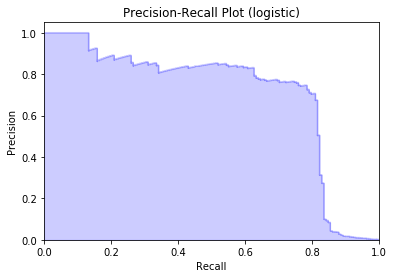

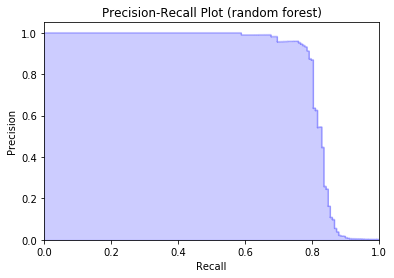

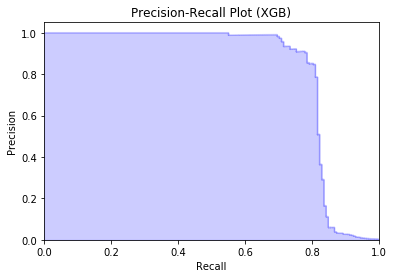

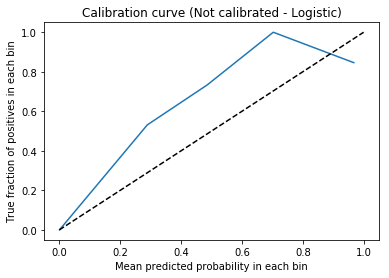

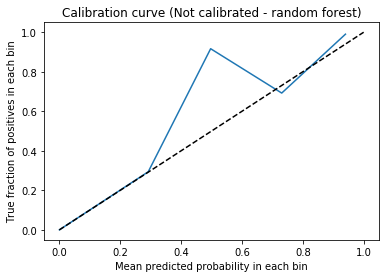

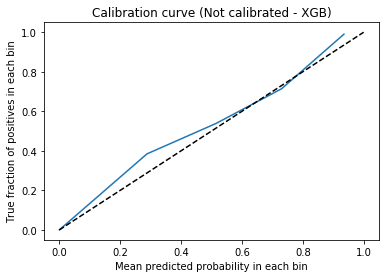

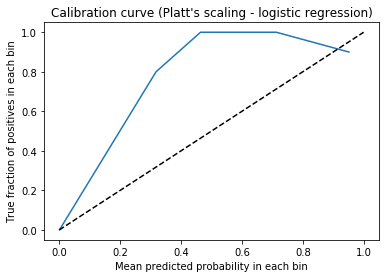

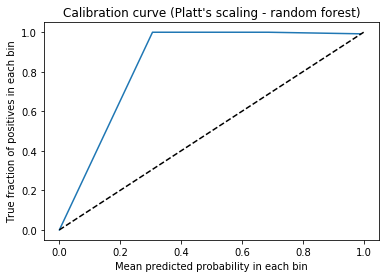

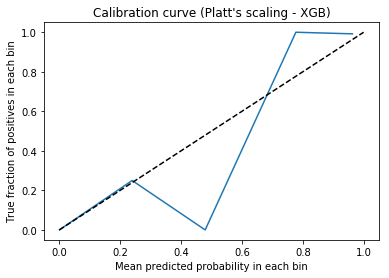

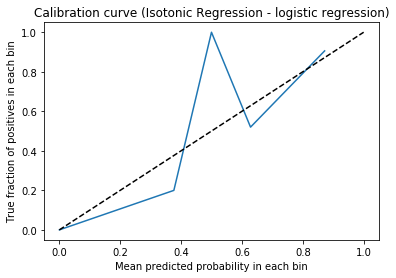

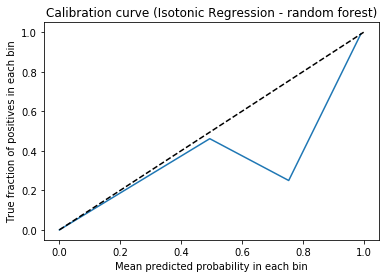

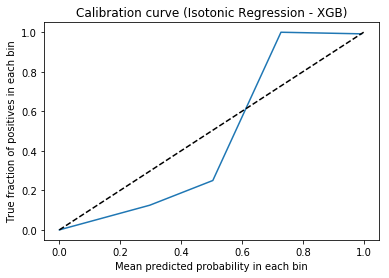

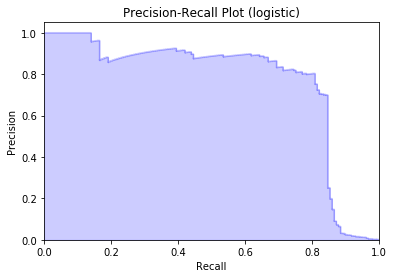

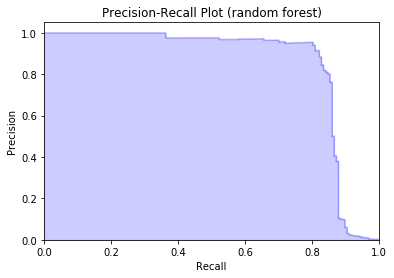

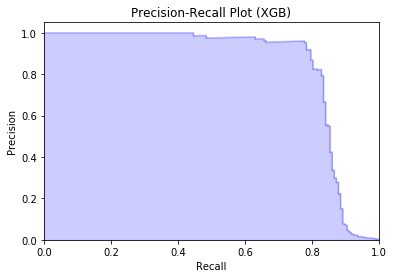

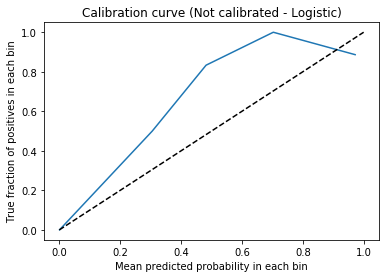

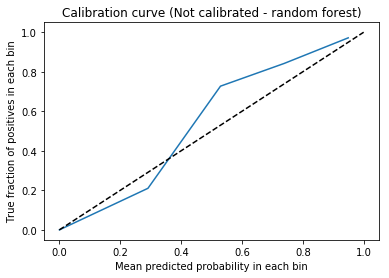

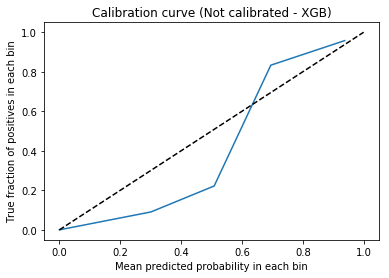

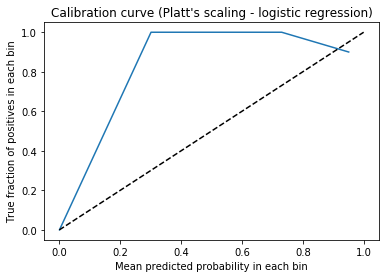

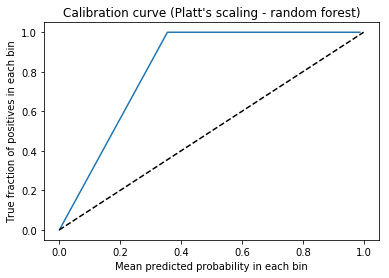

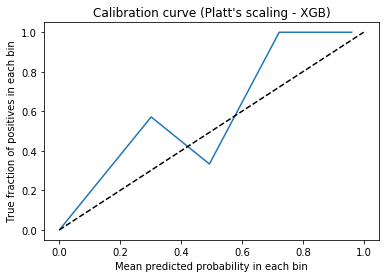

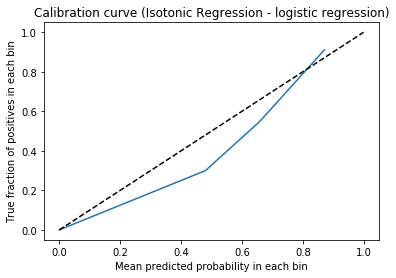

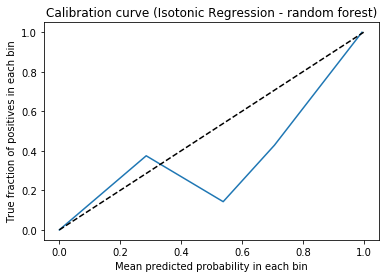

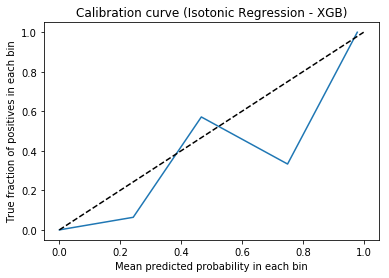

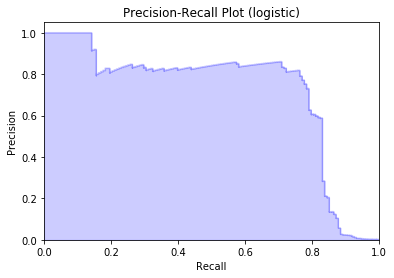

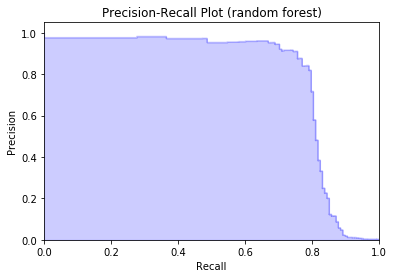

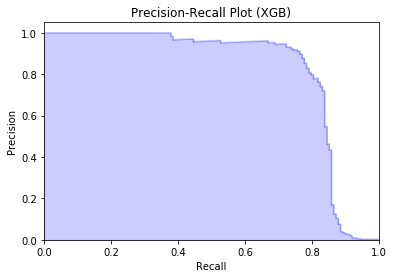

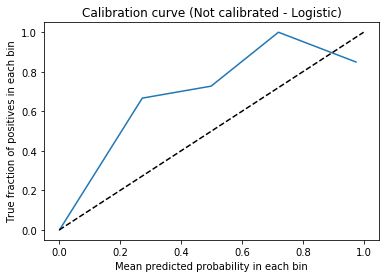

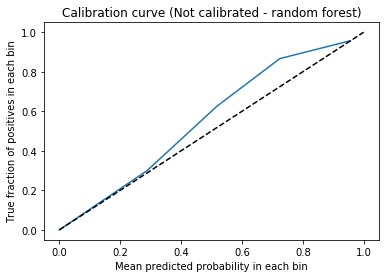

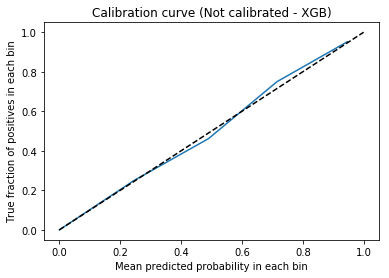

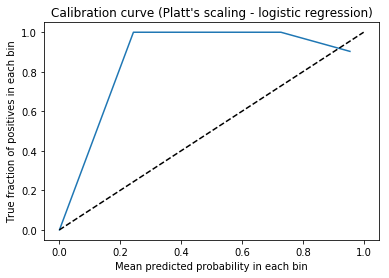

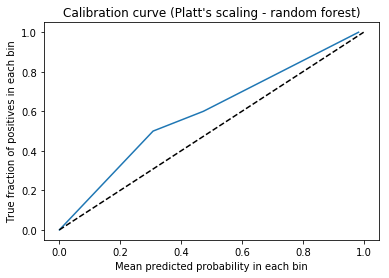

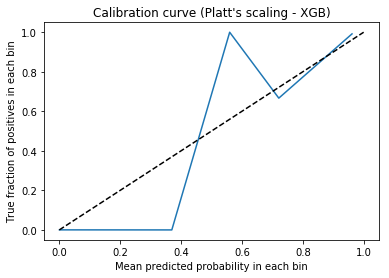

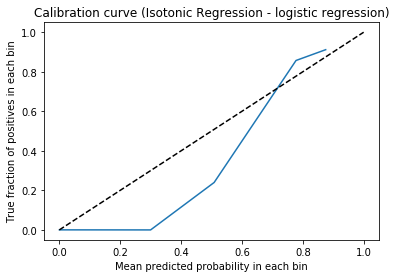

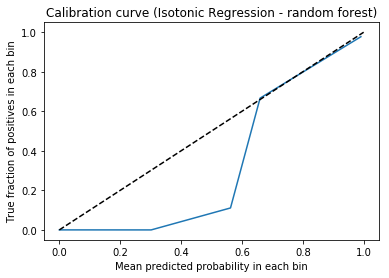

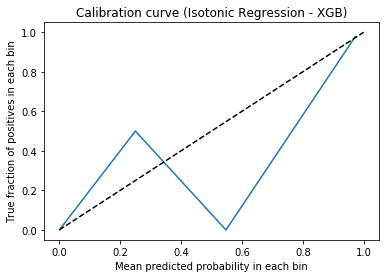

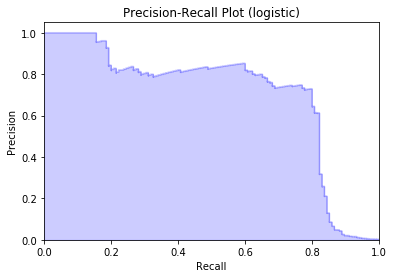

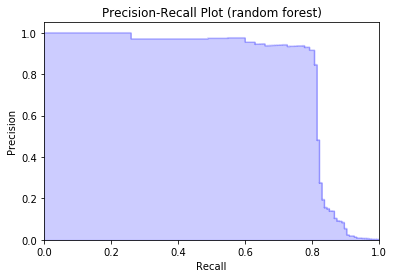

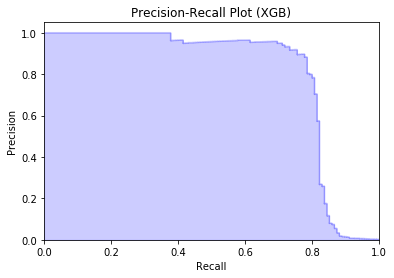

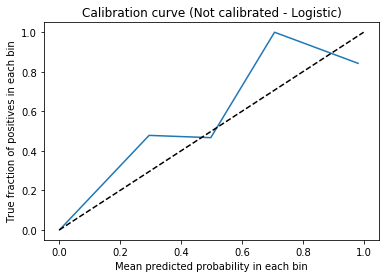

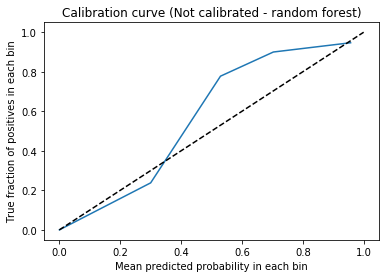

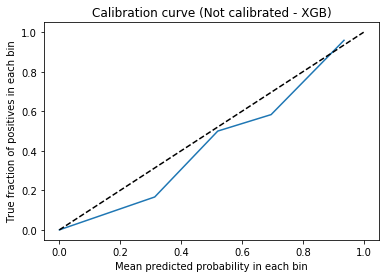

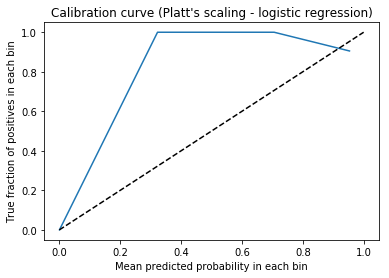

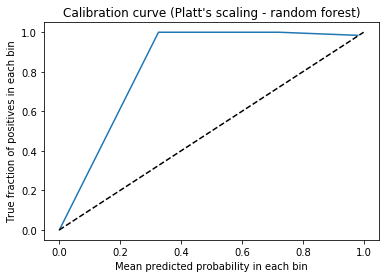

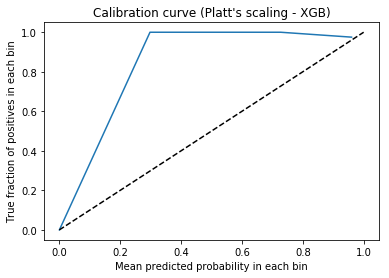

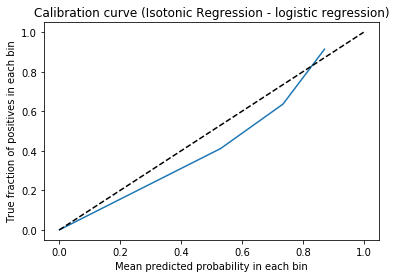

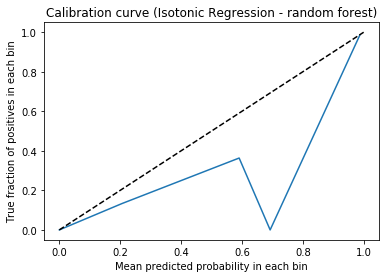

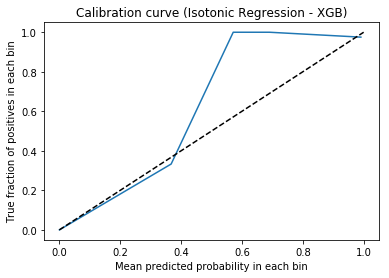

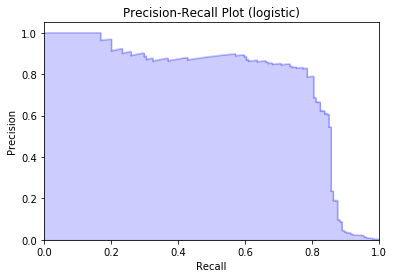

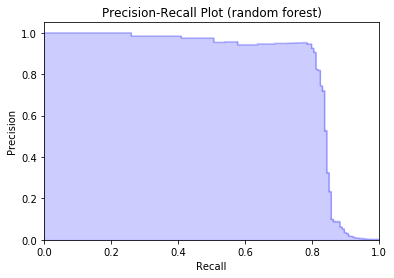

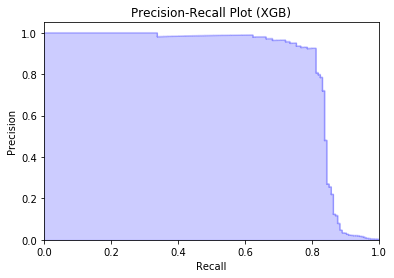

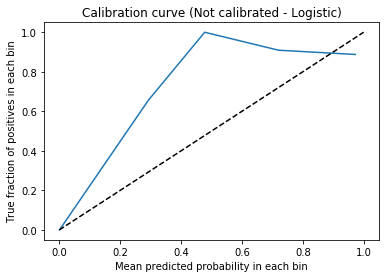

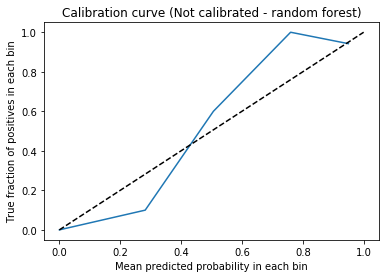

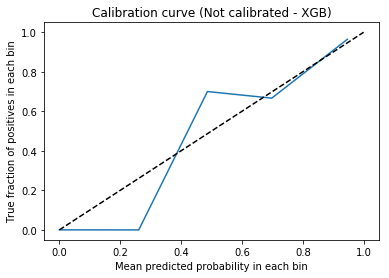

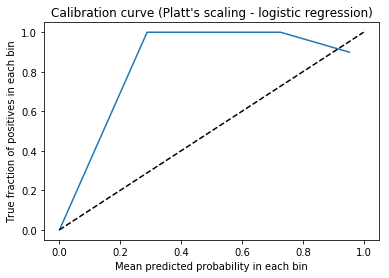

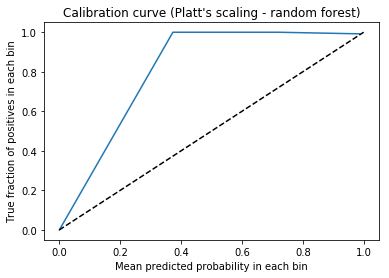

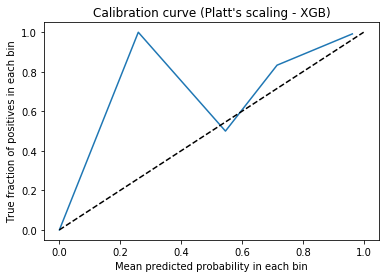

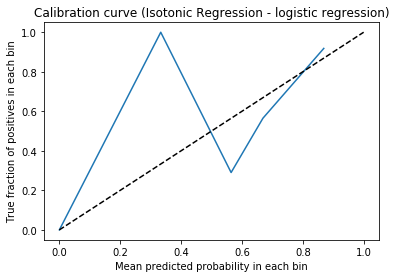

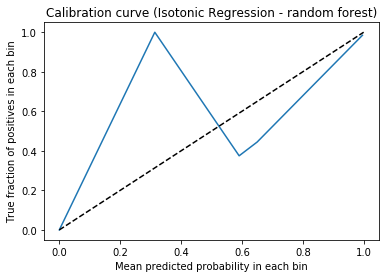

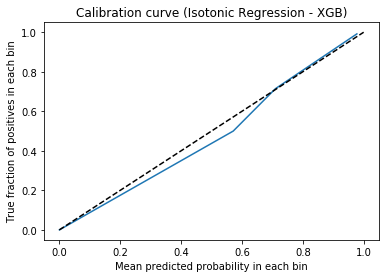

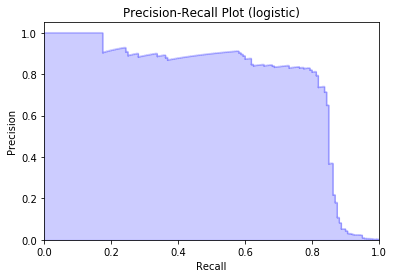

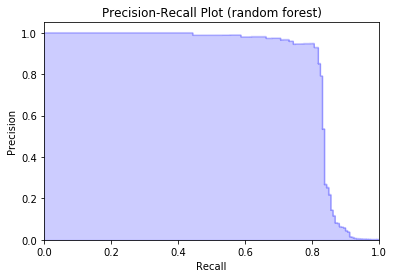

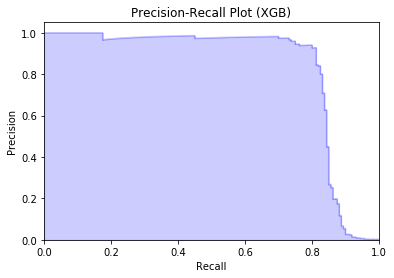

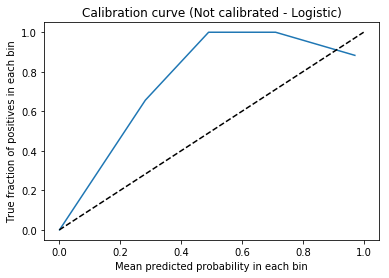

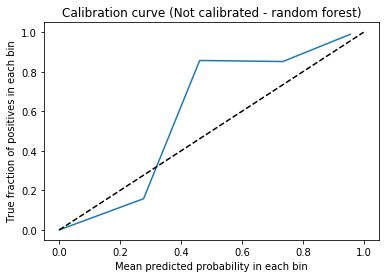

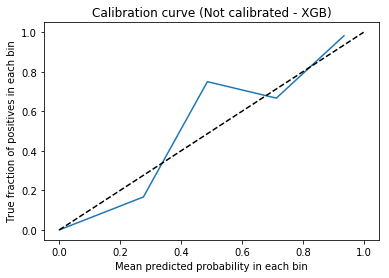

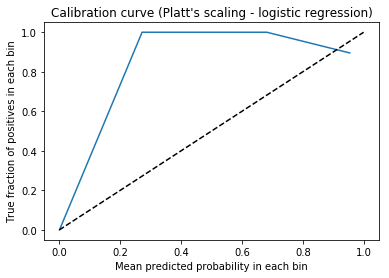

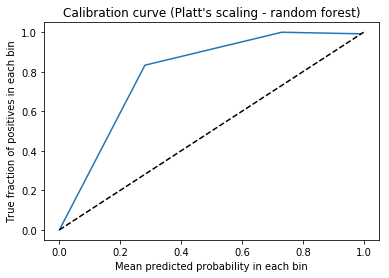

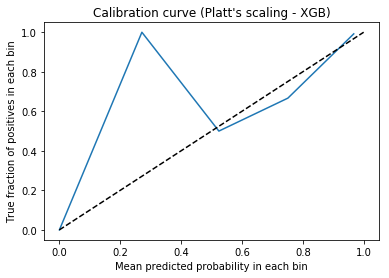

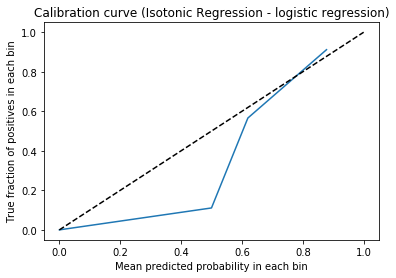

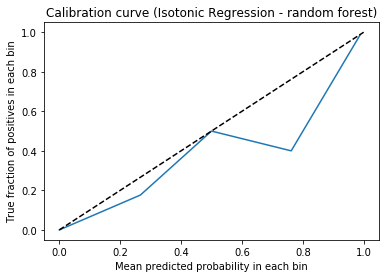

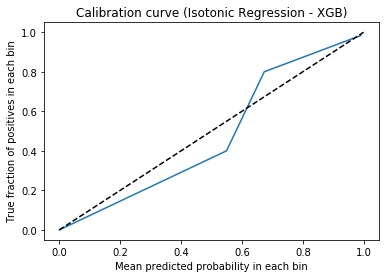

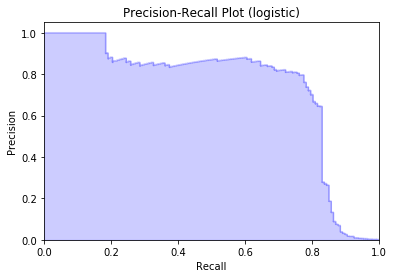

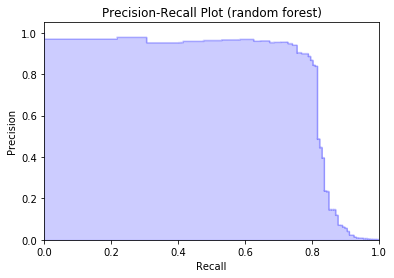

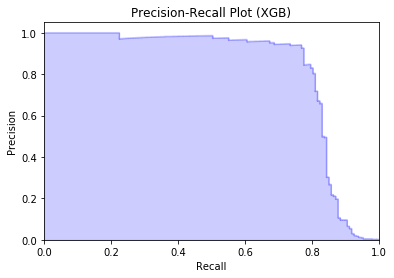

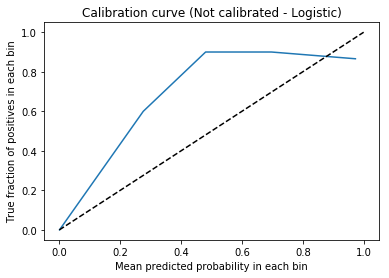

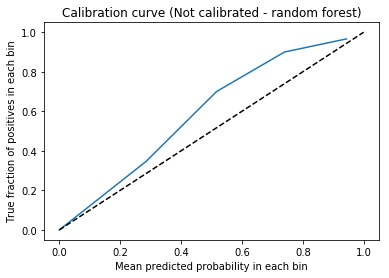

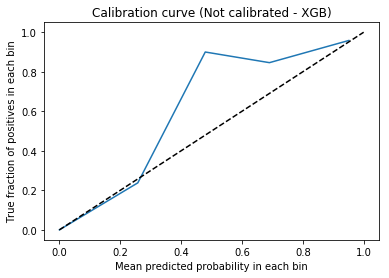

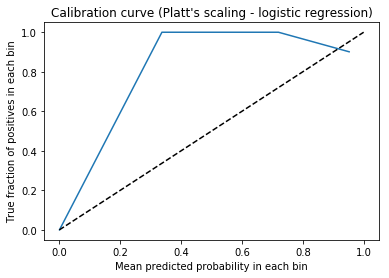

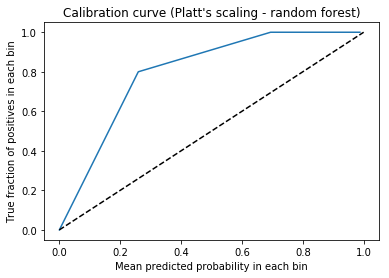

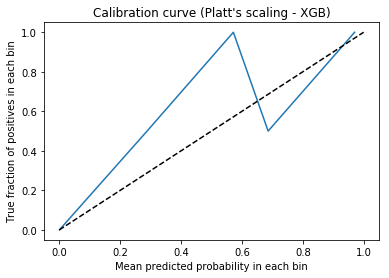

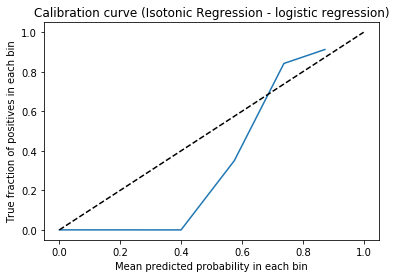

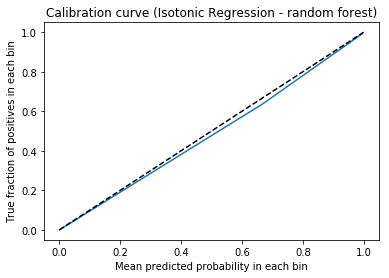

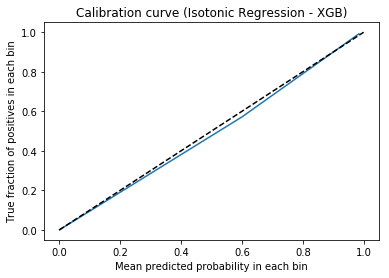

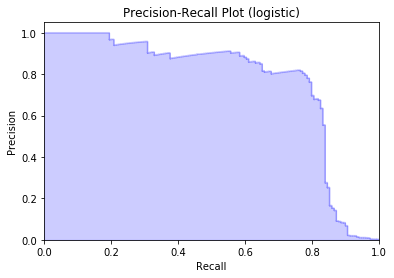

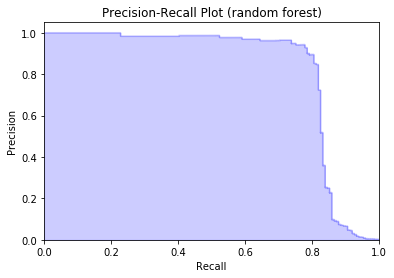

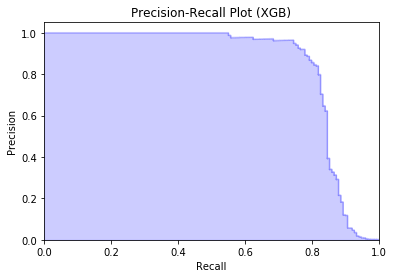

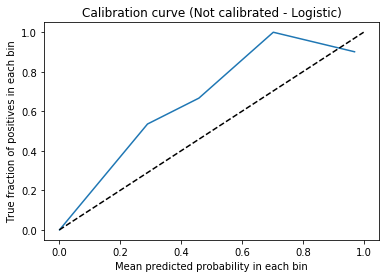

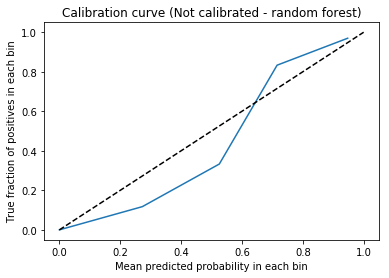

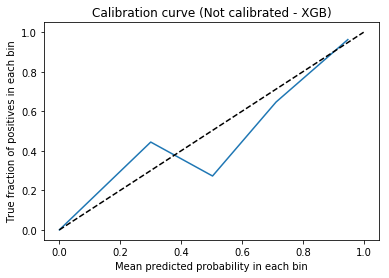

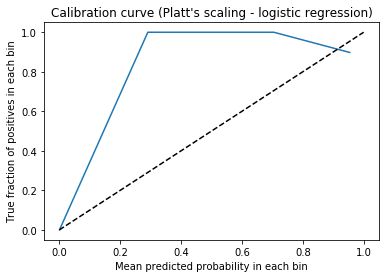

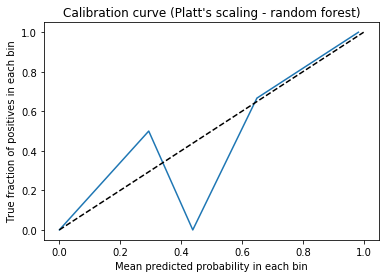

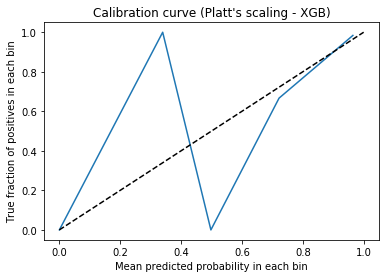

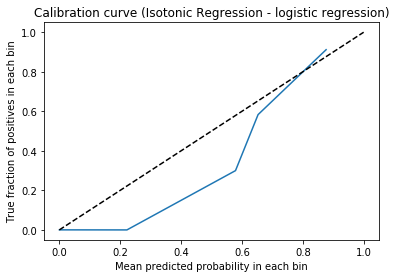

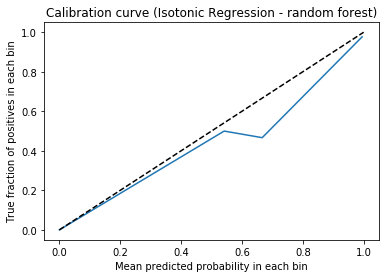

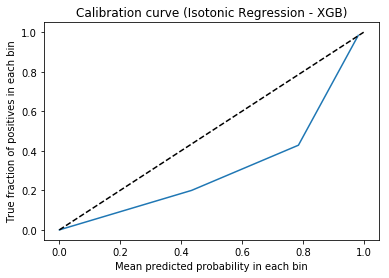

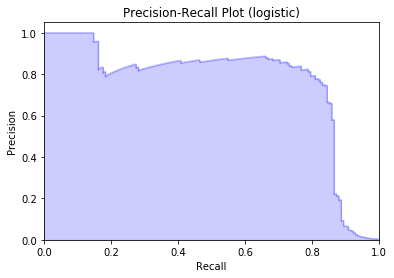

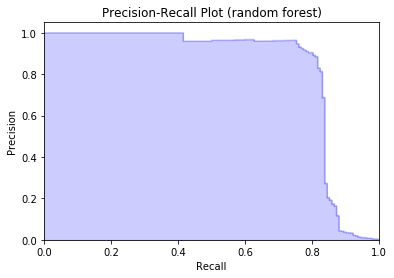

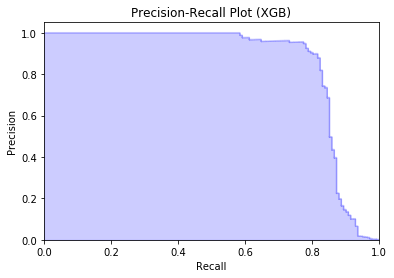

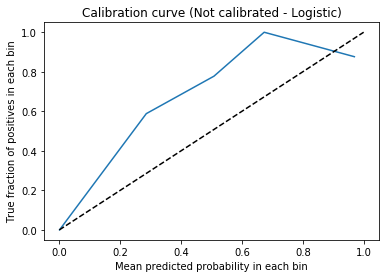

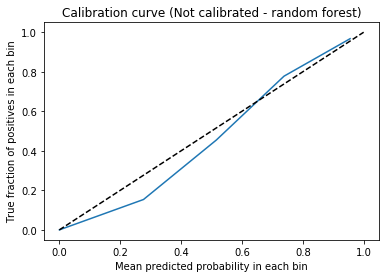

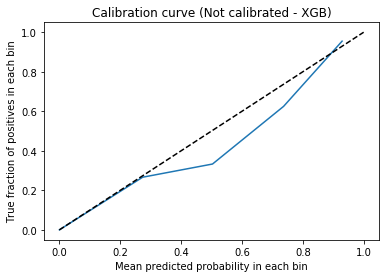

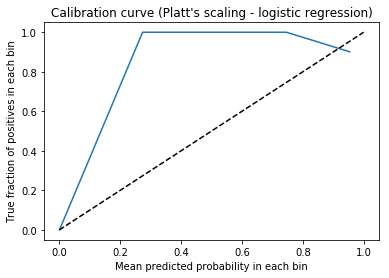

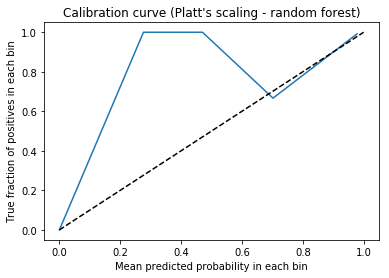

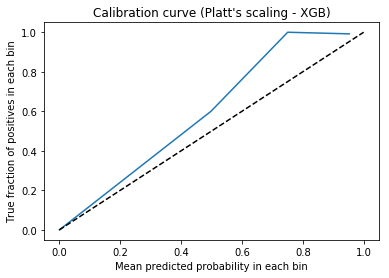

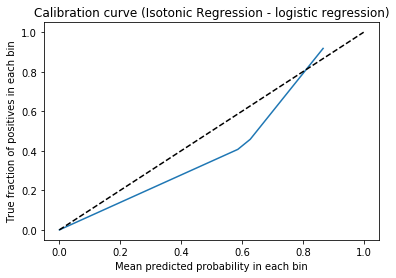

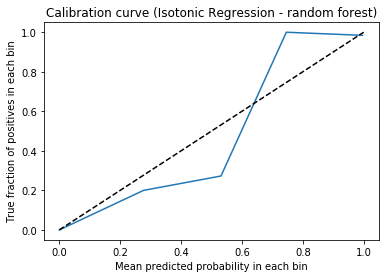

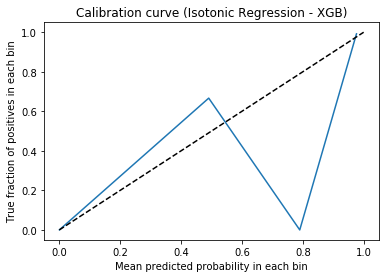

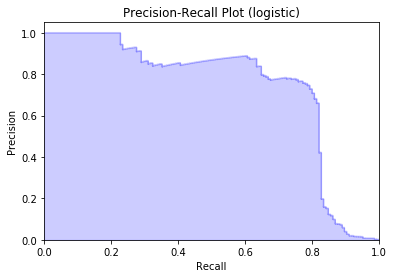

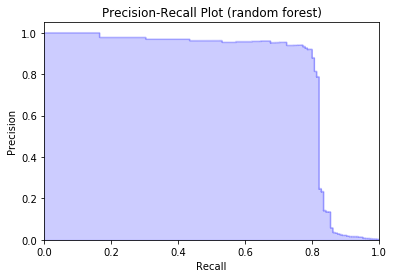

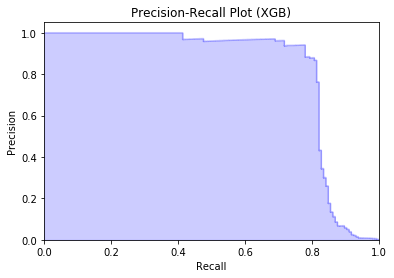

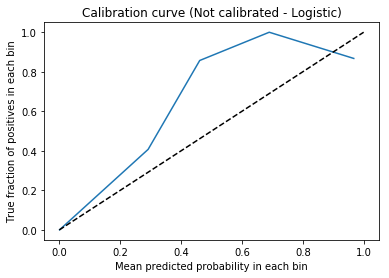

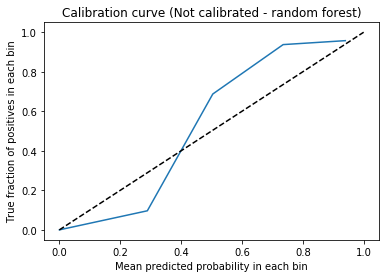

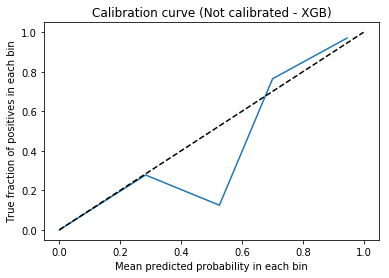

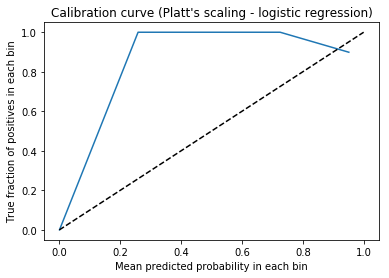

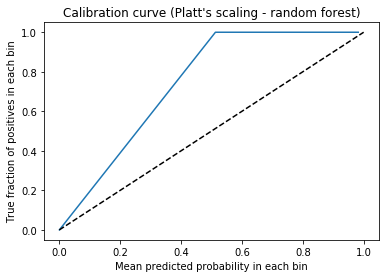

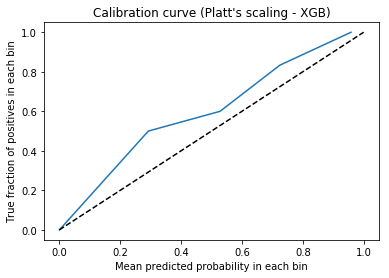

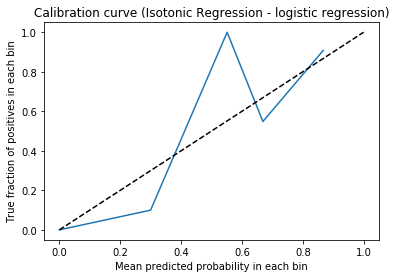

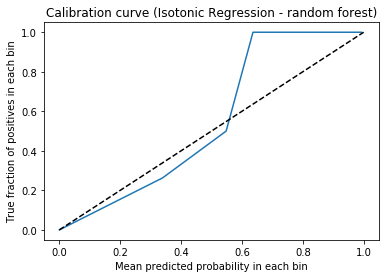

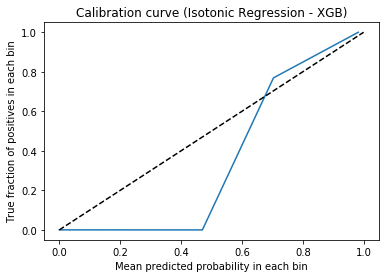

In [162]:
sampling_method_assessment(sampling_method = "Imbalanced")

## Downsampling

In [163]:
metrics_downsampling = np.zeros((3,n_cross_val,len(metrics)))  # Initalization of the metrics matrix

Before computing the optimal parameters for each machine learning model the original data set, which is imabalanced, has to be converted into balanced using the downsampling method (such method is defined in the train_test_generation() function).  Note that there is no interest in splitting into train and test because the grid_search() function already uses cross-validation

In [164]:
x_train, x_test, y_train, y_test = train_test_generation(x = pc, y = data["Class"], sampling_method = "Downsampling")
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))

Computing optimal parameters for downsampled case

In [165]:
# optimal_logistic_downsampling = grid_search(x = x, y = y, model = "logistic_regression")
optimal_logistic_downsampling = {'C': 1}

# optimal_rf_downsampling = grid_search(x = x, y = y, model = "random_forest")
optimal_rf_downsampling = {'max_depth': 13, 'max_features': 10}

# optimal_svm_rbf_downsampling = grid_search(x = x, y = y, model = "SVM_radial")
# optimal_svm_rbf_downsampling = {'C': 1, 'gamma': 1}

# optimal_svm_linear_downsampling = grid_search(x = x, y = y, model = "SVM_linear")
# optimal_svm_linear_downsampling = {'C': 1}

Assessment

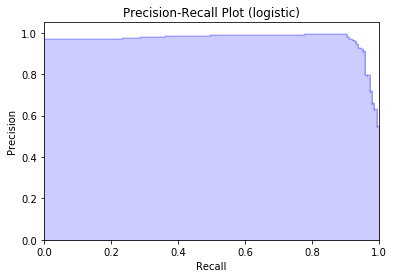

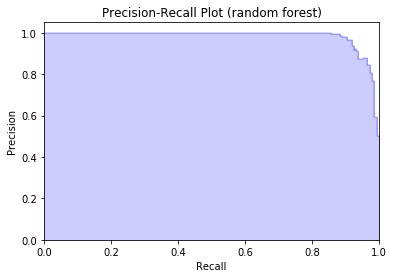

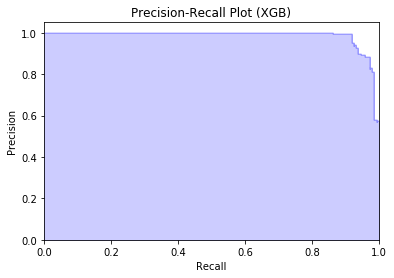

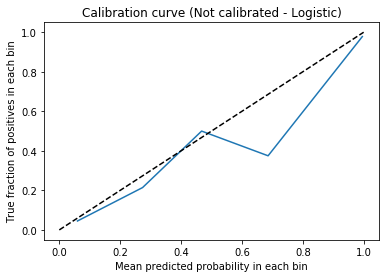

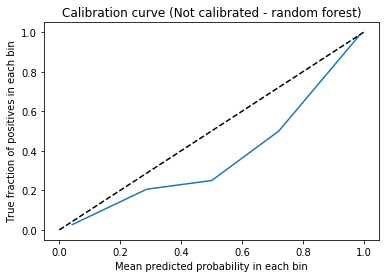

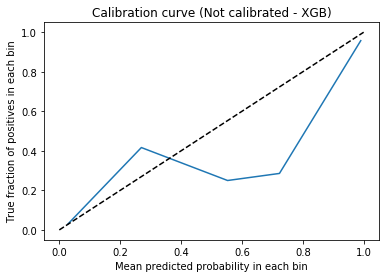

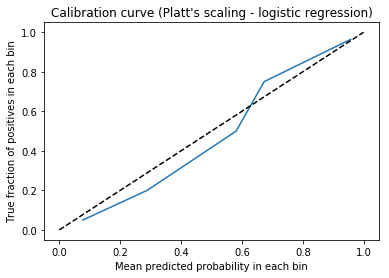

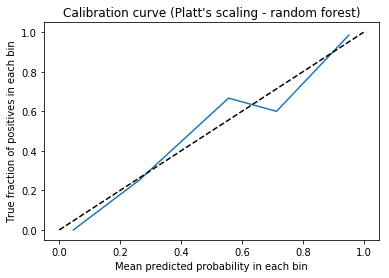

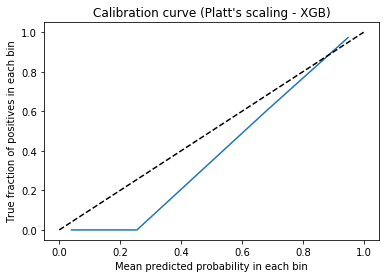

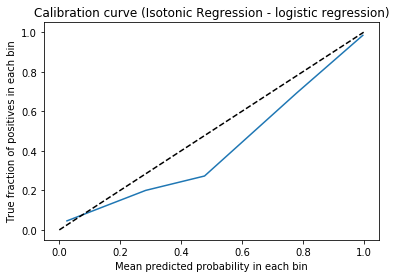

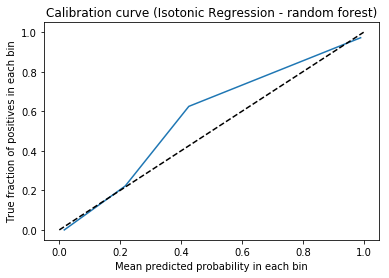

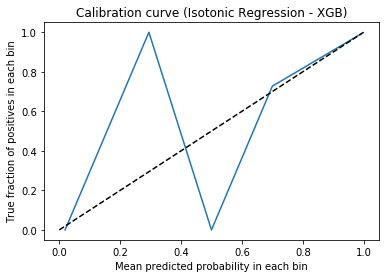

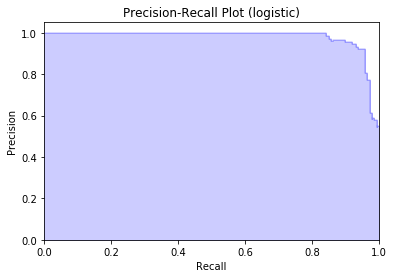

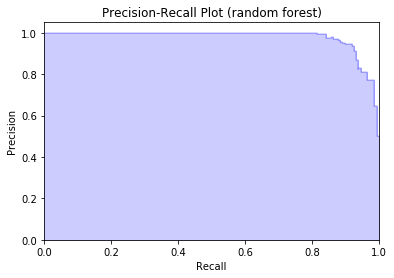

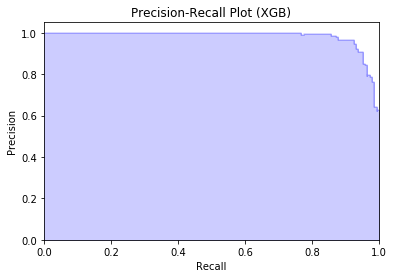

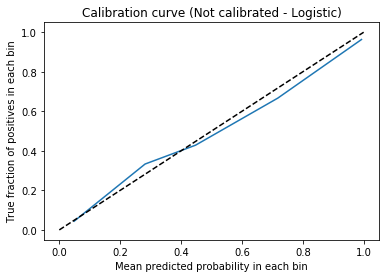

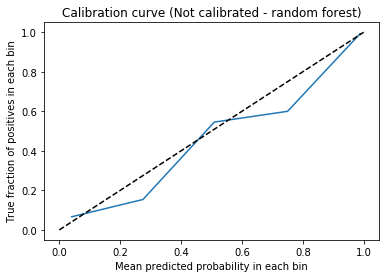

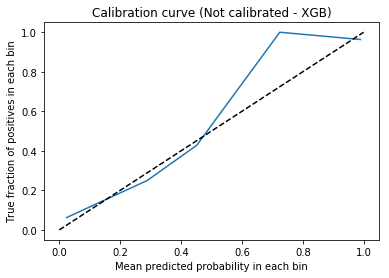

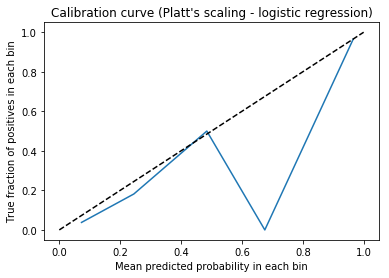

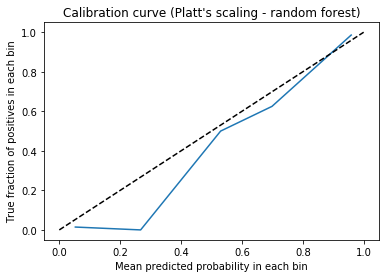

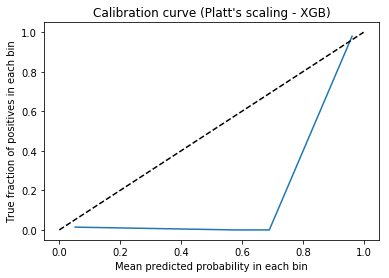

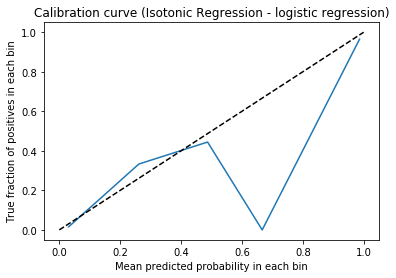

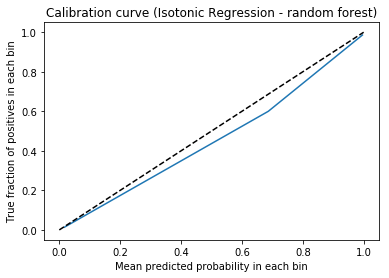

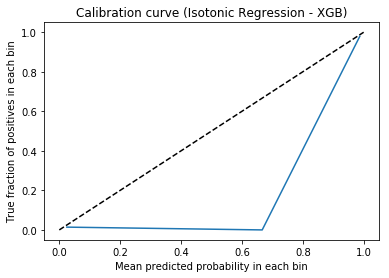

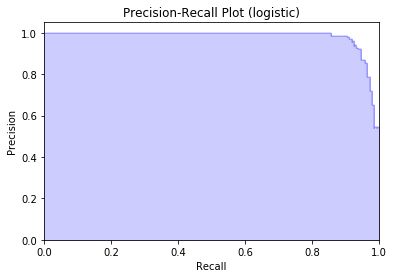

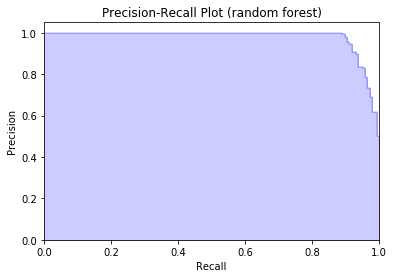

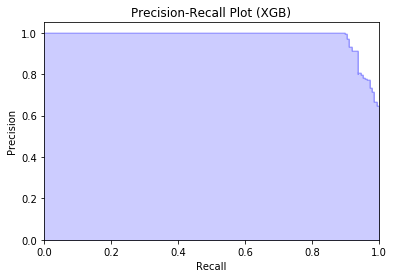

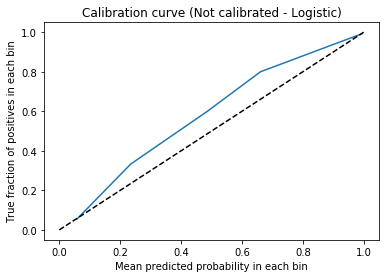

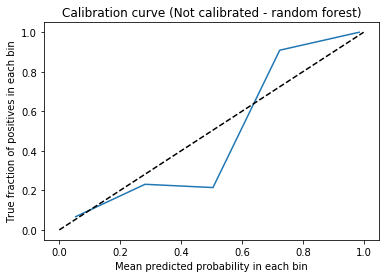

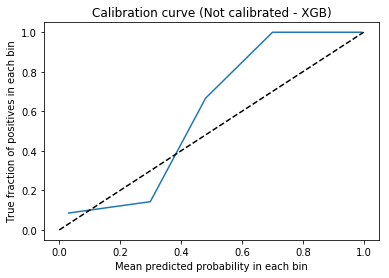

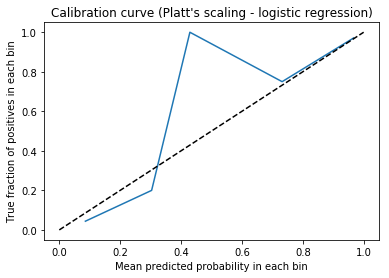

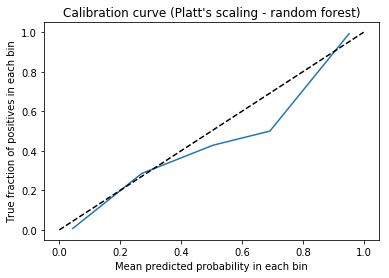

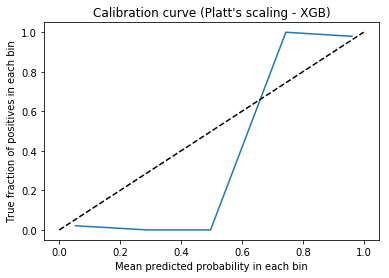

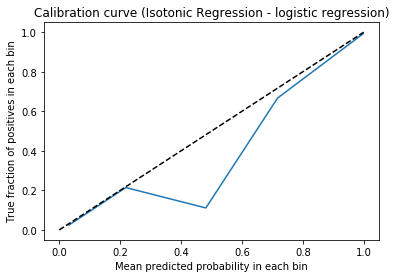

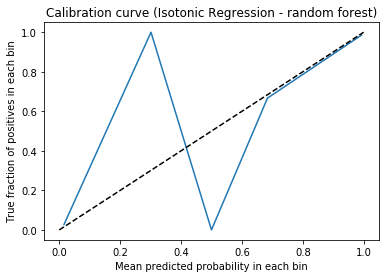

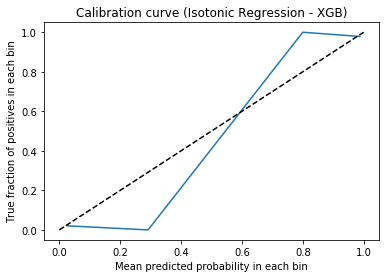

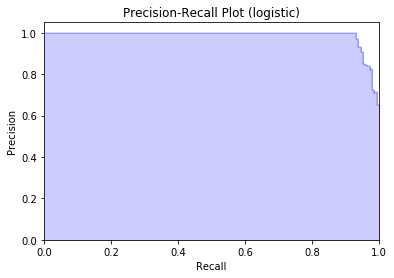

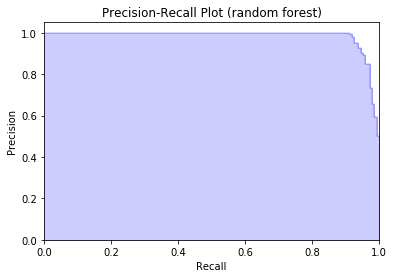

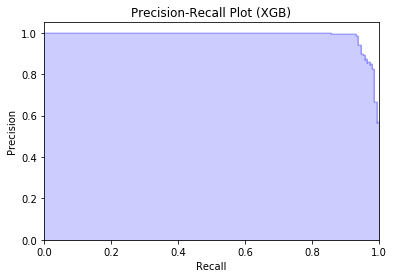

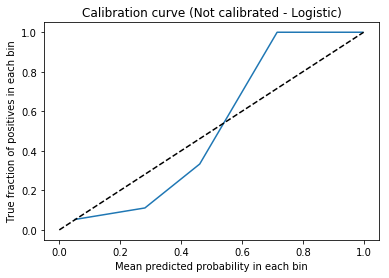

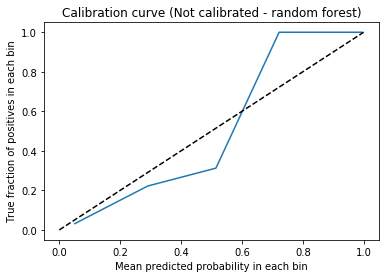

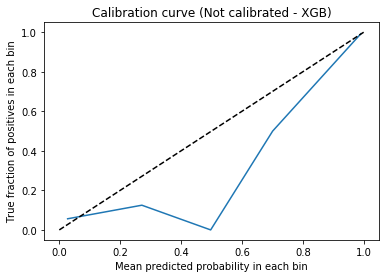

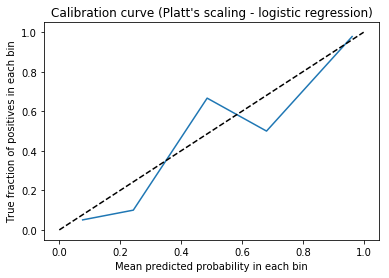

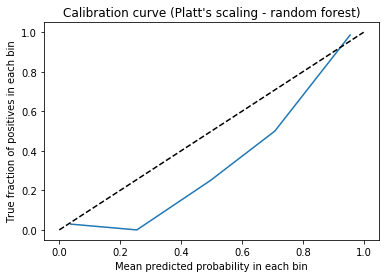

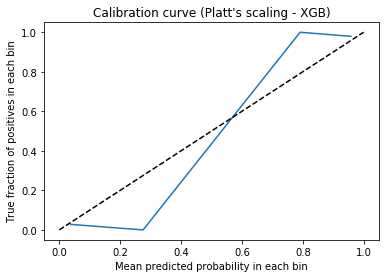

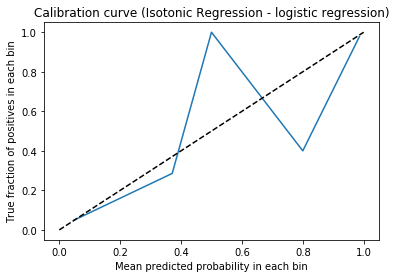

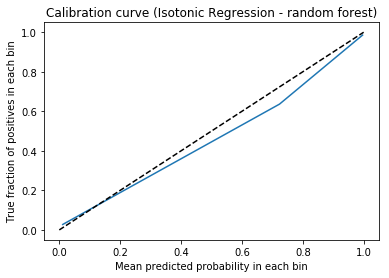

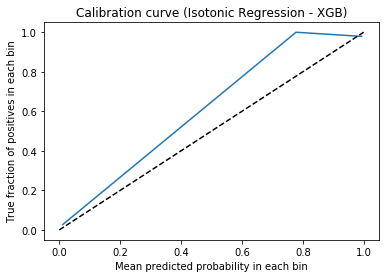

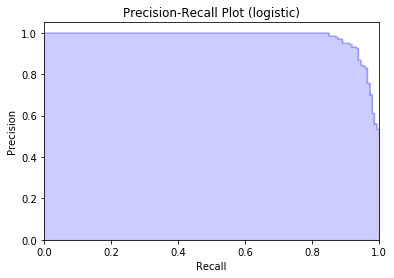

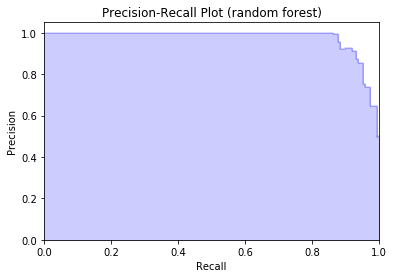

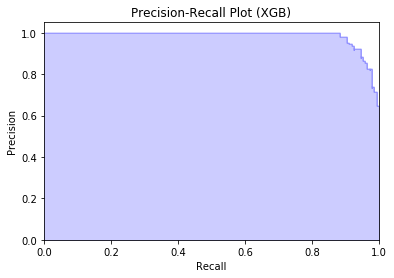

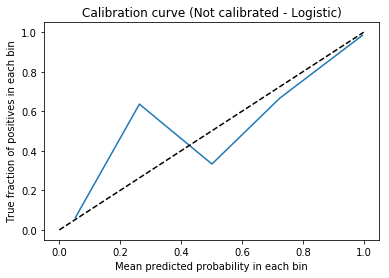

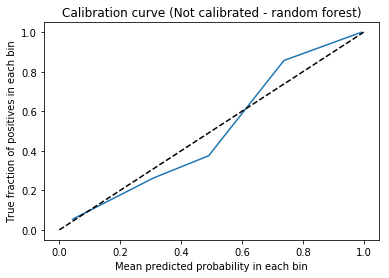

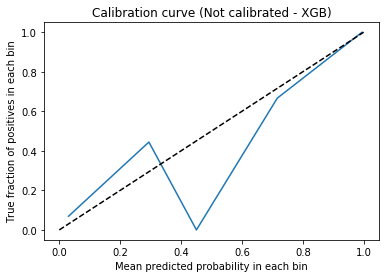

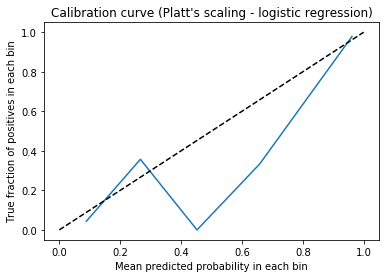

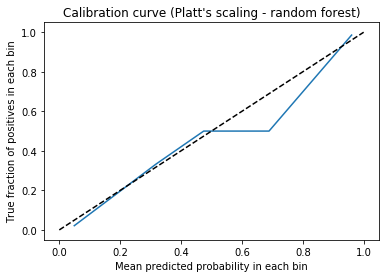

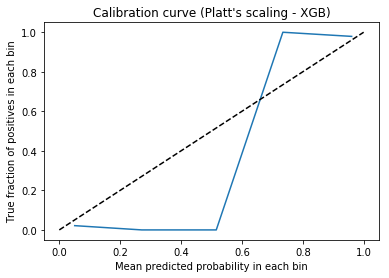

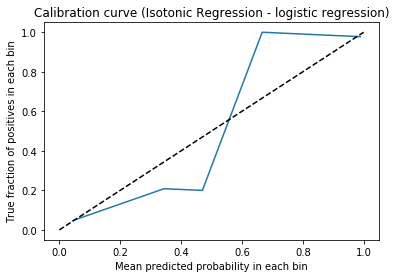

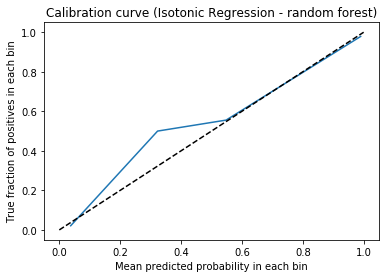

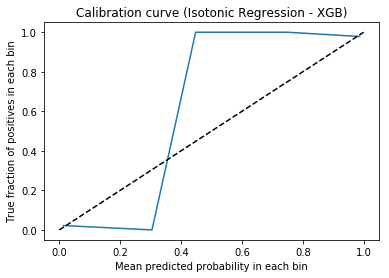

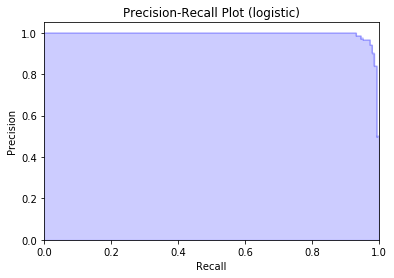

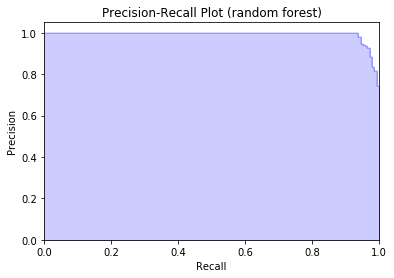

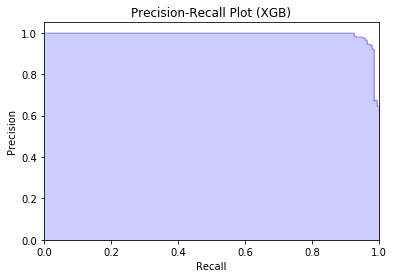

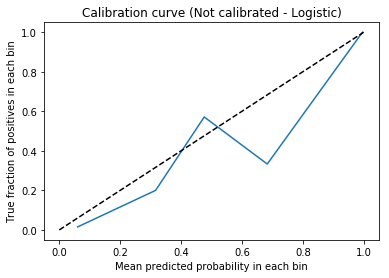

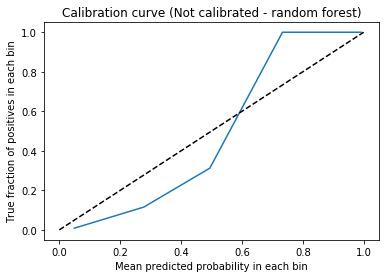

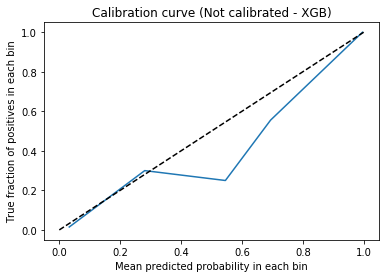

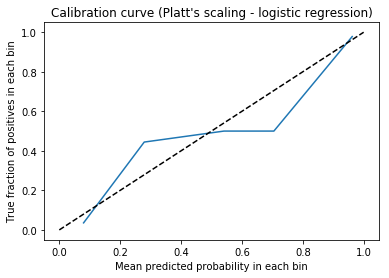

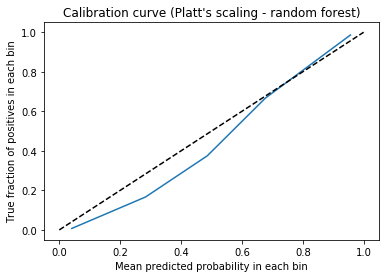

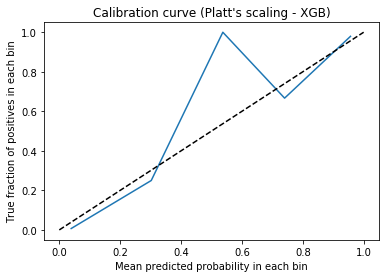

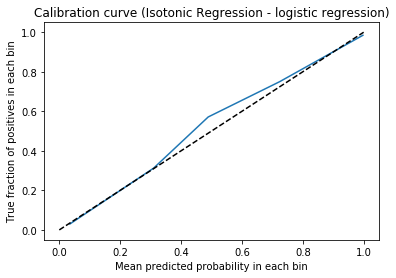

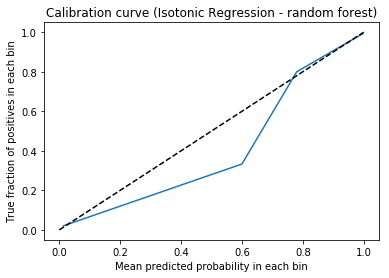

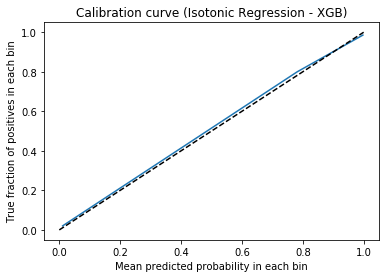

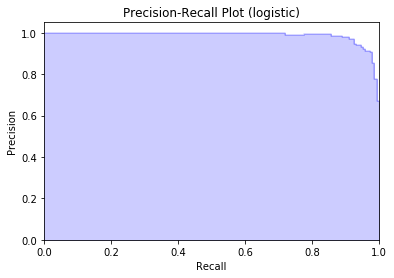

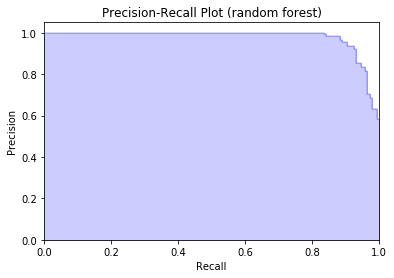

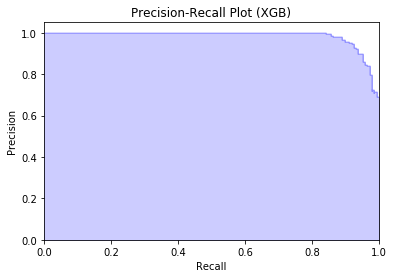

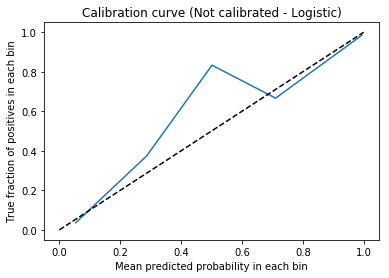

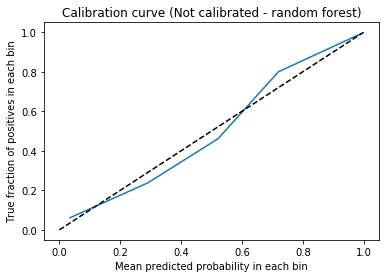

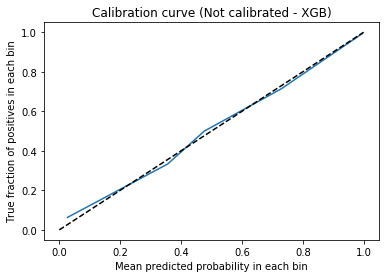

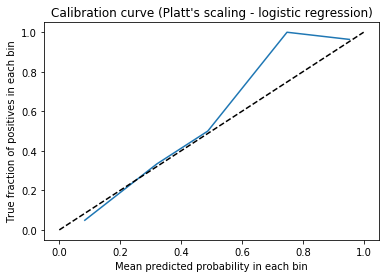

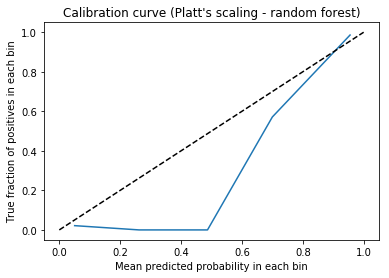

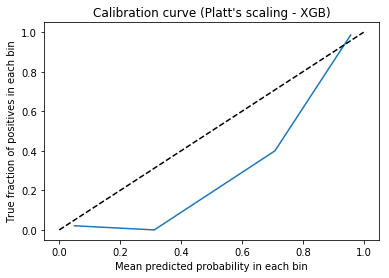

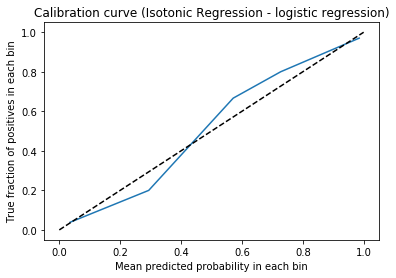

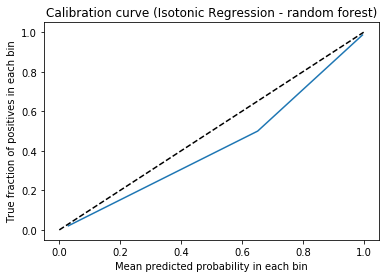

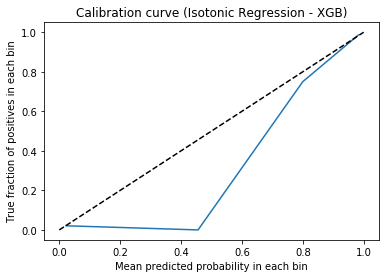

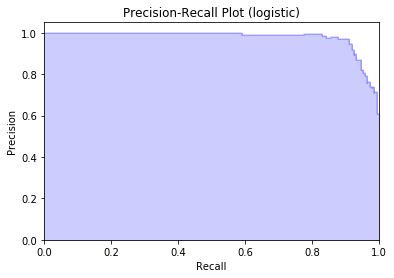

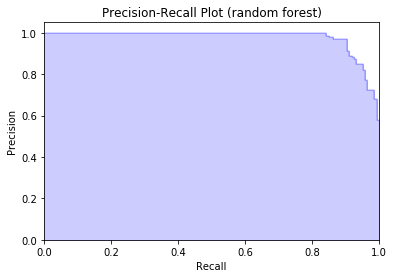

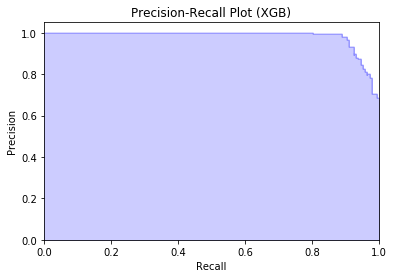

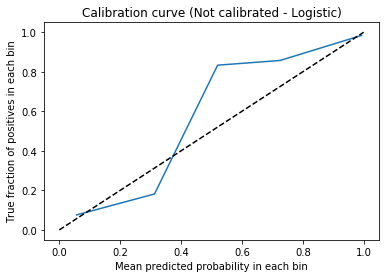

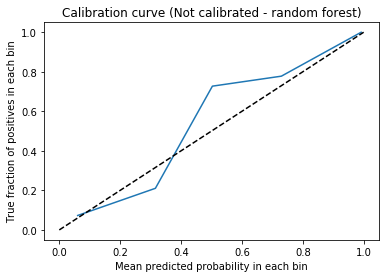

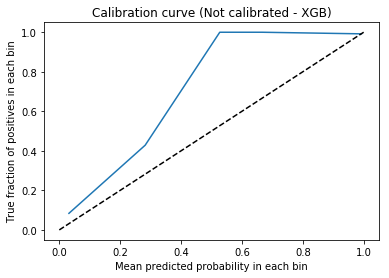

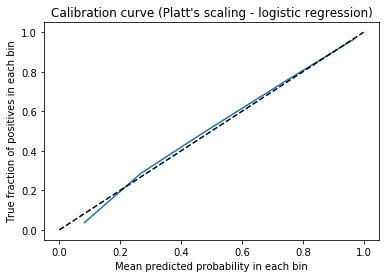

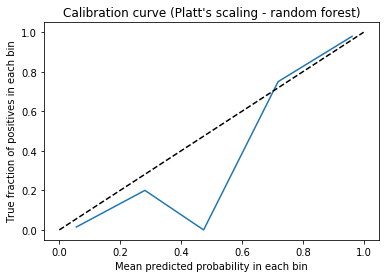

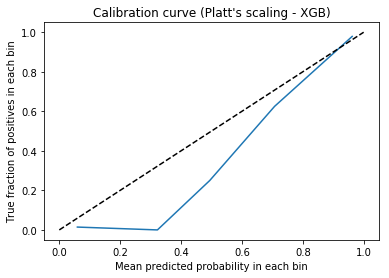

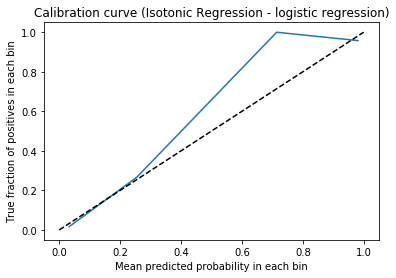

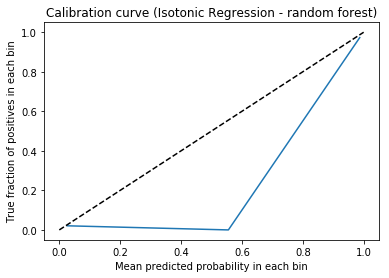

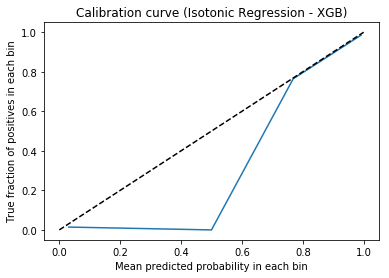

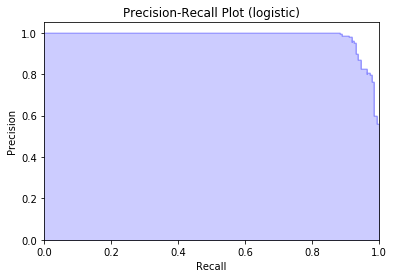

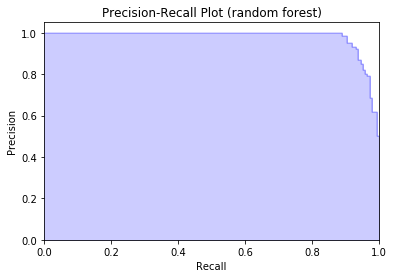

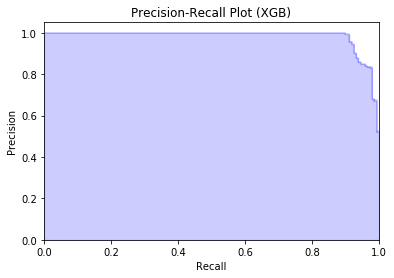

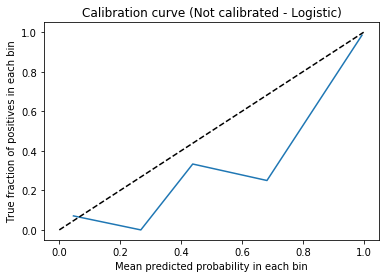

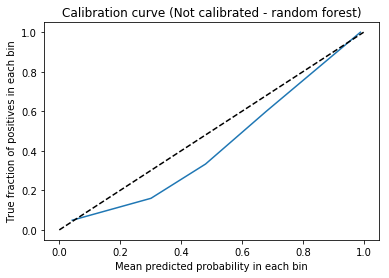

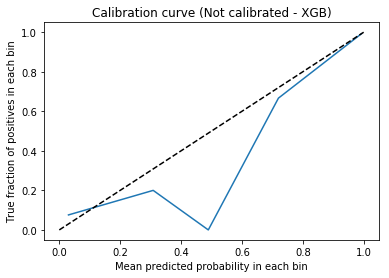

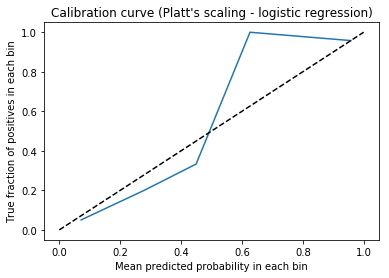

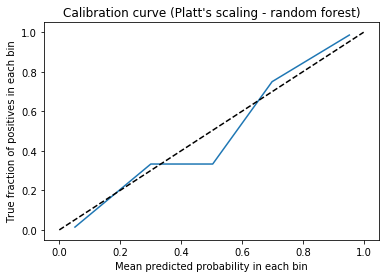

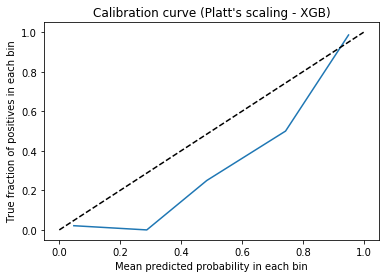

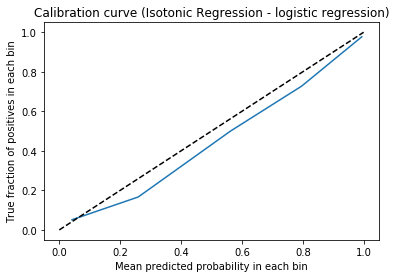

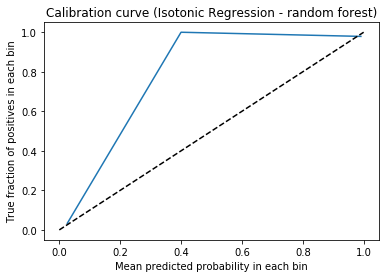

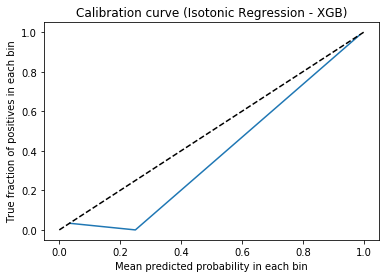

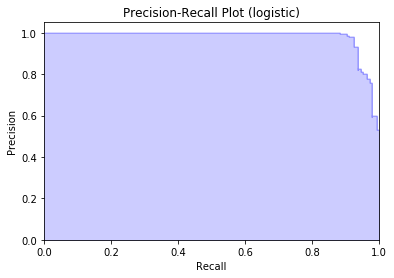

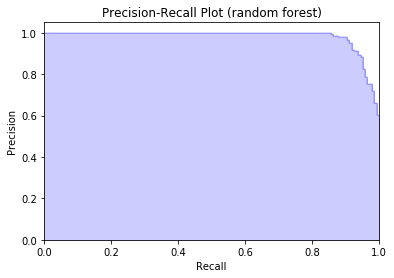

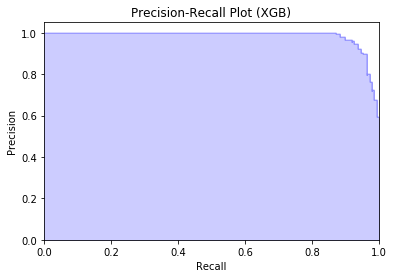

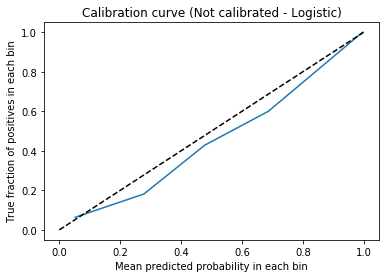

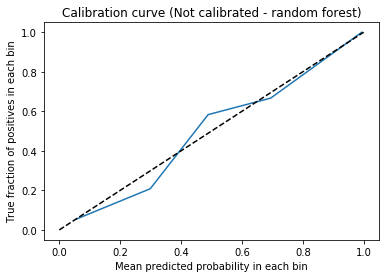

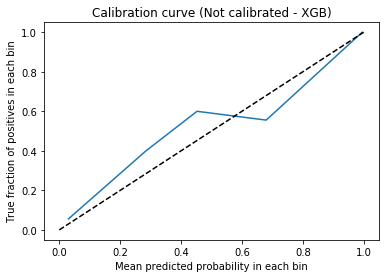

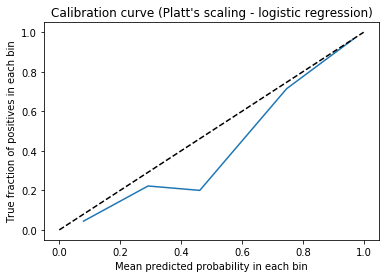

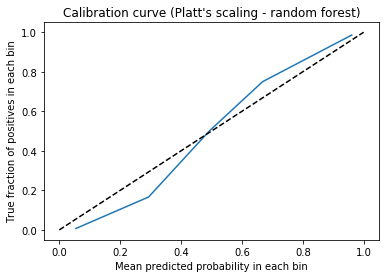

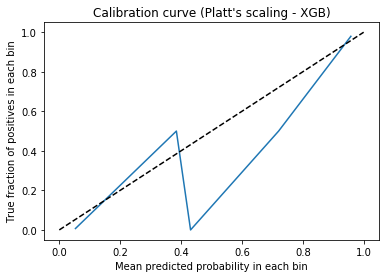

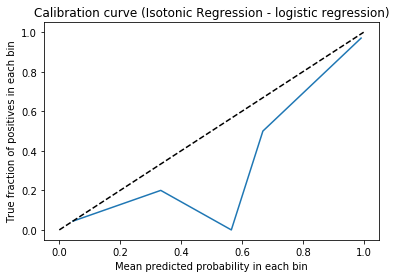

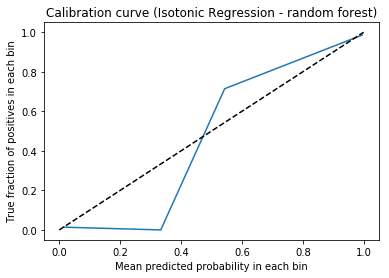

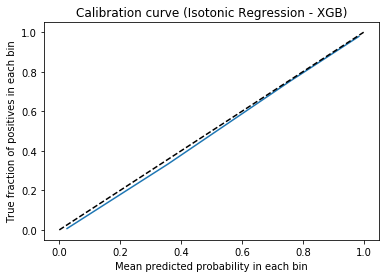

In [166]:
sampling_method_assessment(sampling_method = "Downsampling")

## Upsampling

In [ ]:
#metrics_upsampling = np.zeros((3,n_cross_val,len(metrics)))   # Initalization of the metrics matrix

Again, before computing the optimal parameters for each machine learning model the original data set, which is imabalanced, has to be converted into balanced using the upsampling method (such method is defined in the train_test_generation() function).  Note that there is no interest in splitting into train and test because the grid_search() function already uses cross-validation

In [ ]:
#x_train, x_test, y_train, y_test = train_test_generation(pc, data["Class"], sampling_method = "Upsampling")
#x = np.concatenate((x_train,x_test))
#y = np.concatenate((y_train,y_test))

In [ ]:
# optimal_logistic_upsampling = grid_search(x = x, y = y, model = "logistic_regression")
#optimal_logistic_upsampling = {'C': 1}

# optimal_rf_upsampling = grid_search(x = x, y = y, model = "random_forest")
#optimal_rf_upsampling = {'max_depth': 13, 'max_features': 10}

# optimal_svm_rbf_upsampling = grid_search(x = x, y = y, model = "SVM_radial")
# optimal_svm_rbf_upsampling = {'C': 1, 'gamma': 1}

# optimal_svm_linear_upsampling = grid_search(x = x, y = y, model = "SVM_linear")
# optimal_svm_linear_upsampling = {'C': 1}

Assessment

In [ ]:
#sampling_method_assessment(sampling_method = "Upsampling")

## Results performance imbalanced, downsampling and upsampling

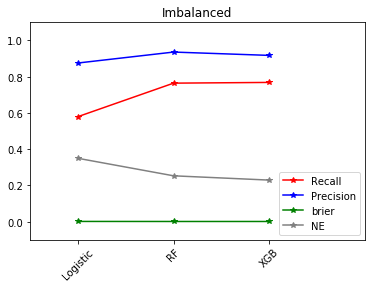

In [167]:
metrics_plot(sampling_method = "Imbalanced")

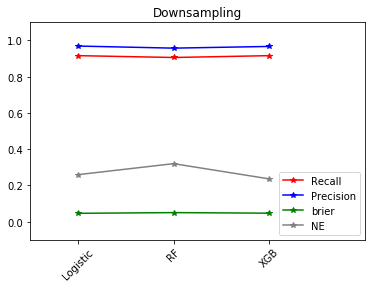

In [168]:
metrics_plot(sampling_method = "Downsampling")

In [169]:
# metrics_plot(sampling_method = "Upsampling")

## Negative downsampling

Percentage of 0s used: 0.1%, 0.2%, 0.4%, 0.5%, 0.6%, 0.7%, 0.8%, 0.9%, 1%, 5%, 8%, 10% in negative downsampling. In order to assess which weight is the best only one metric will be used: normalized entropy. The goal is to see how the normalized entropy changes as we increase the amount of observations with label 0 (majority class) and maintaining the amount of observation with label 1 (minority class)

In [197]:
weights_neg_down = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04] # Proportion of 0 used in the dataset
ne_neg_down = np.zeros((n_cross_val, len(weights_neg_down))) # Matrix where the values of normalized entropy are saved for each weight

The normalized entropy is computed using the predicted probabilities of XGBoost which semms to be a stable model from the previous sampling methods

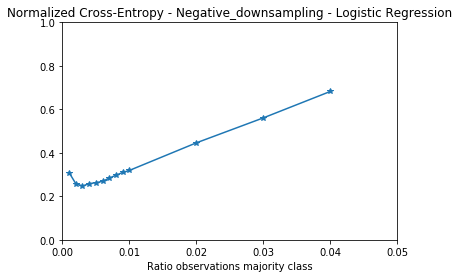

In [198]:
weighted_sampling_method_assessment(sampling_method = "Negative_downsampling")

## Positive upsampling

Percentage of 1s used with respect to 0s: 0.2%, 0.4%, 0.5%, 0.6%, 0.7%, 0.8%, 0.9%, 1%, 10% in positive upsampling. Again, in order to assess which weight is the best only one metric will be used: normalized entropy. The goal is to see how the normalized entropy changes as we increase the amount of observations with label 0 (majority class) and maintaining the amount of observation with label 1 (minority class)

In [33]:
# weights_pos_up = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.1] # Proportion of 1s wrt 0s used in the dataset
# ne_pos_up = np.zeros((n_cross_val, len(weights_pos_up))) # Matrix where the values of normalized entropy are saved for each weight

Again, the normalized entropy is computed using the predicted probabilities of XGBoost which semms to be a stable model from the previous sampling methods

In [34]:
# weighted_sampling_method_assessment(sampling_method = "Positive_upsampling")

## Conclusion

- Negative downsampling: When using very few number of observations with label 0 (majority class) the performance of the model is poor. The normalized cross entropy achieves it minimum when the percentage 0s that we use is 0.8%, which corresponds to 0.008*284315 = 2275 observations. Given that there are a total of 492 observations with label 1, we end up using 2275/492 = times mores 0s than 1s. So balanced sampling is not always optimal

## To do

- Check if there is an implementation of Platt's scaling on sklearn
- In negative downsampling and positive downsampling, obtain several performance curves and compute the mean for each weight
- Add SMOTE